In [1]:
import json
import csv
import pandas as pd
import sqlite3
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.pyplot import hist
import numpy as np
import datetime

In [2]:
ls

Feature_Engineering_100.ipynb  profit_from_zero_log.png
Feature_Validation.ipynb       profit_ratio_log.png
GAS-ETH.csv                    relative_buy.png
avg_trans_log.png              relative_sell.png
buy_interval_log.png           since_minted_log.png
combined_corr.png              std_trans_log.png
currency_combined.png          time_corr.png
currency_corr.png              transfer_ratio.png
in_degree_log.png              unique_in_ratio.png
max_trans_log.png              unique_out_dist.png
network_combined.png           unique_out_dist_norm.png
network_corr.png               unique_out_ratio.png


In [3]:
conn = sqlite3.connect('../nft_database_100.db')
c = conn.cursor()

In [4]:
df_all= pd.read_sql_query("SELECT * from combined", conn)
print(df_all.shape)
df_all.head()

(1137198, 20)


,block_number,block_timestamp,transaction_hash,value,contract_type,transaction_type,token_address,token_id,from_address,to_address,amount,date,name,tokenCount,onSaleCount,rank_allTime,volume_allTime,ETH-USD,price,GAS-USD
0,15669425,2022-10-03T18:30:59.000Z,0xa4b20310f320343a55e91e9e8d5884a9d402424a1099...,0.0,ERC721,Single,0xa8abf045fe1a9ef0583e436393a6e4e0b483f717,210030130,0x744a1ee51766d9d30229a46b62ef84a8a481470f,0x95933de7546f9dfad542860355cfe2fae1e5e843,1,03-Oct-22-06:30:59 PM,CryptoSpells,1047,5,2767,237.59036,1323.439209,0.0,2.268938
1,15661059,2022-10-02T14:28:11.000Z,0x011ec97fe3af952b9d0e2985b25e0e336c14cf63614a...,0.0,ERC721,Single,0xa8abf045fe1a9ef0583e436393a6e4e0b483f717,210020208,0x5df4660295bed7abc783480c7d28d8c015cfb37a,0x95933de7546f9dfad542860355cfe2fae1e5e843,1,02-Oct-22-02:28:11 PM,CryptoSpells,1047,5,2767,237.59036,1276.093506,0.0,2.239082
2,15521784,2022-09-12T16:10:00.000Z,0x099a149c51eecbe9e160c45c8ba011cf0138f401ded5...,0.0,ERC721,Single,0xa8abf045fe1a9ef0583e436393a6e4e0b483f717,210020209,0x5df4660295bed7abc783480c7d28d8c015cfb37a,0x95933de7546f9dfad542860355cfe2fae1e5e843,1,12-Sep-22-04:10:00 PM,CryptoSpells,1047,5,2767,237.59036,1713.765259,0.0,2.523954
3,15521128,2022-09-12T13:35:34.000Z,0x8945a05c09434a07073087b4e2ec6c0fa3375e579476...,0.0,ERC721,Single,0xa8abf045fe1a9ef0583e436393a6e4e0b483f717,210020210,0x5df4660295bed7abc783480c7d28d8c015cfb37a,0x95933de7546f9dfad542860355cfe2fae1e5e843,1,12-Sep-22-01:35:34 PM,CryptoSpells,1047,5,2767,237.59036,1713.765259,0.0,2.523954
4,15518827,2022-09-12T04:13:22.000Z,0x10c86d7d001cee6bb21946f1c7efaa1a72fbe9fc4b54...,0.0,ERC721,Single,0xa8abf045fe1a9ef0583e436393a6e4e0b483f717,210040100,0x5df4660295bed7abc783480c7d28d8c015cfb37a,0xbcdc510d5f4976559a49f38a7db81c4fabb0030c,1,12-Sep-22-04:13:22 AM,CryptoSpells,1047,5,2767,237.59036,1713.765259,0.0,2.523954


In [5]:
df_wallets = pd.read_sql_query("SELECT * from all_wallets", conn)
df_wallets = df_wallets[df_wallets["address"] != "0x0000000000000000000000000000000000000000"]
df_wallets.head()

,address
0,0x744a1ee51766d9d30229a46b62ef84a8a481470f
1,0x5df4660295bed7abc783480c7d28d8c015cfb37a
2,0x3d41199226f984505d7be029057c23be4a44795e
3,0x543154e6914d93a137b0749d2e6432a4d597df49
4,0xb240163d43e29e2d1f5b7c00e0f6da0f2b7ca79d


In [6]:
df_wallets = df_wallets[df_wallets['address'] != '0x429e38081e4b3c227143af9eda6e6776cc2c4cb1']

In [7]:
df_wallets.shape[0]

252924

## Network Features

### In-Degree (total number of sellers an account has interacted with)

In [13]:
buy_df = pd.read_sql_query("SELECT block_timestamp,to_address as address from combined", conn)
buys = df_wallets.merge(buy_df, how = 'left')
buys = buys.groupby(['address']).count()
buys = buys.rename(columns={'block_timestamp':'in-degree'})
buys = buys.reset_index()
buys.head()

,address,in-degree
0,0x0000000000000000000000000000000000000001,41
1,0x000000000000000000000000000000000000d3a0,15
2,0x000000000000000000000000000000000000dead,6487
3,0x000000000000660def84e69995117c0176ba446e,1
4,0x000000000000fd461ca2d54e8f4b3e37749df921,2


##### Vis & Analysis

In [10]:
print(buys.describe())
print("account number:",buys.shape[0])

          in-degree
count  252924.00000
mean        4.44462
std        50.04387
min         1.00000
25%         1.00000
50%         2.00000
75%         3.00000
max     10163.00000
account number: 252924


<AxesSubplot:>

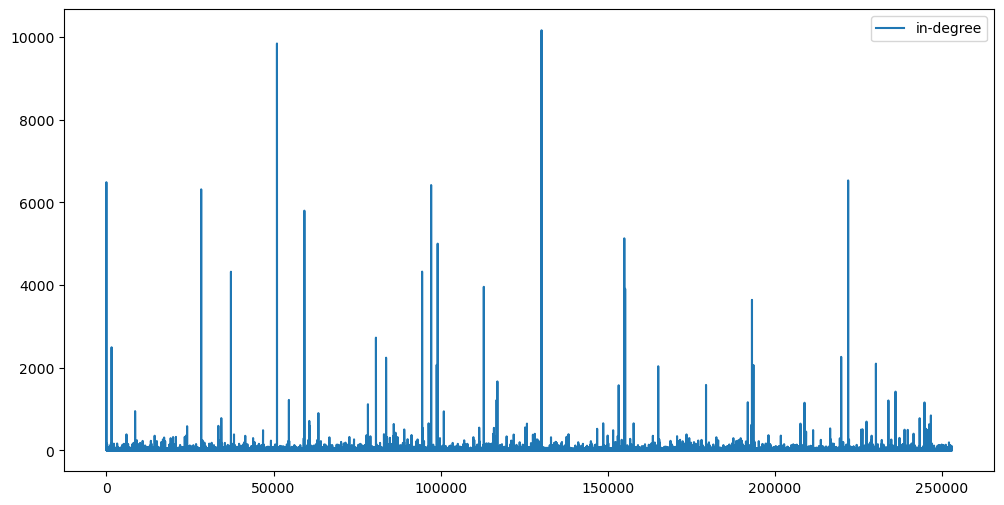

In [11]:
buys.plot(figsize=((12,6)))

In [12]:
sorted_buys = buys.sort_values(by=['in-degree'], ascending=False).reset_index(drop=True)
sorted_buys.head()

,address,in-degree
0,0x83c8f28c26bf6aaca652df1dbbe0e1b56f8baba2,10163
1,0x335a46e5de67986e2f0f251e00acd605b3c9a691,9843
2,0xe052113bd7d7700d623414a0a4585bcae754e9d5,6530
3,0x000000000000000000000000000000000000dead,6487
4,0x620b70123fb810f6c653da7644b5dd0b6312e4d8,6418


In [13]:
sorted_buys = sorted_buys.groupby(['in-degree']).count().reset_index()
sorted_buys = sorted_buys.rename(columns={"address":"count"})
sorted_buys

,in-degree,count
0,1,113110
1,2,57350
2,3,23410
3,4,13560
4,5,10004
...,...,...
335,6418,1
336,6487,1
337,6530,1
338,9843,1


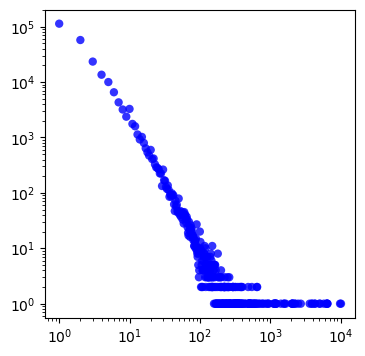

In [14]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_buys['in-degree'] ,sorted_buys['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

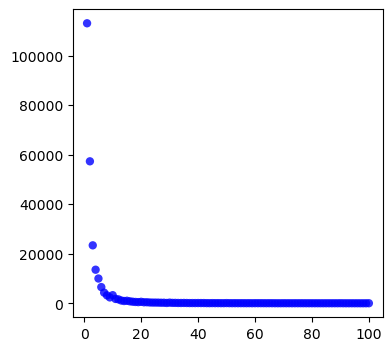

In [15]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_buys.iloc[0:100]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['in-degree'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

### Out-Degree (total number of buyers an account has interacted with)

In [8]:
sell_df = pd.read_sql_query("SELECT block_timestamp,from_address as address from combined", conn)
sells = df_wallets.merge(sell_df, how = 'left')
sells = sells.groupby(['address']).count()
sells = sells.rename(columns={'block_timestamp':'out-degree'})
sells = sells.reset_index()
sells.head()

,address,out-degree
0,0x0000000000000000000000000000000000000001,0
1,0x000000000000000000000000000000000000d3a0,0
2,0x000000000000000000000000000000000000dead,0
3,0x000000000000660def84e69995117c0176ba446e,1
4,0x000000000000fd461ca2d54e8f4b3e37749df921,2


##### Vis & Analysis

In [17]:
print(sells.describe())
print("account number:",sells.shape[0])

          out-degree
count  252924.000000
mean        2.422783
std        28.154222
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max     10163.000000
account number: 252924


<AxesSubplot:>

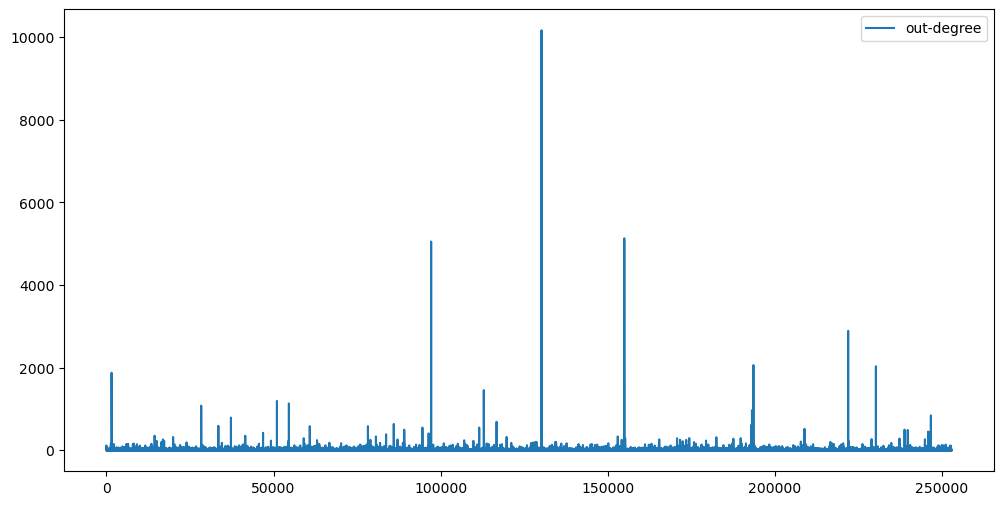

In [18]:
sells.plot(figsize=((12,6)))

In [19]:
sorted_sells = sells.sort_values(by=['out-degree'], ascending=False).reset_index(drop=True)
sorted_sells = sorted_sells.groupby(['out-degree']).count().reset_index()
sorted_sells = sorted_sells.rename(columns={"address":"count"})
sorted_sells

,out-degree,count
0,0,97940
1,1,69734
2,2,36201
3,3,13747
4,4,8116
...,...,...
230,2060,1
231,2889,1
232,5050,1
233,5129,1


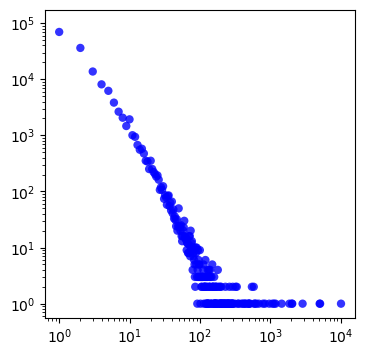

In [20]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_sells['out-degree'] ,sorted_sells['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

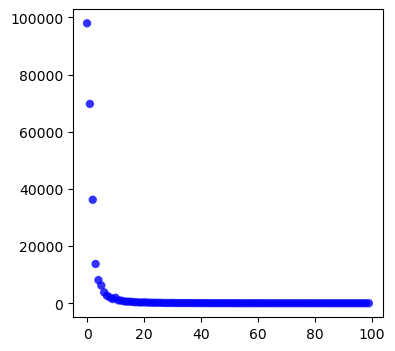

In [21]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_sells.iloc[0:100]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['out-degree'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

### Unique In-Degree (total number of distinct sellers an account has interacted with)

In [9]:
unique_in_df = pd.read_sql_query("SELECT to_address as address,from_address as seller from combined", conn)
unique_in_df = unique_in_df.drop_duplicates()
unique_in_df = df_wallets.merge(unique_in_df, how = 'left')
unique_in_df = unique_in_df.groupby(['address']).count()
unique_in_df = unique_in_df.rename(columns={'seller':'unique in-degree'})
unique_in_df = unique_in_df.reset_index()
unique_in_df.head()

,address,unique in-degree
0,0x0000000000000000000000000000000000000001,2
1,0x000000000000000000000000000000000000d3a0,1
2,0x000000000000000000000000000000000000dead,2453
3,0x000000000000660def84e69995117c0176ba446e,1
4,0x000000000000fd461ca2d54e8f4b3e37749df921,2


##### Vis & Analysis

In [23]:
print(unique_in_df.describe())
print("account number:",unique_in_df.shape[0])

       unique in-degree
count     252924.000000
mean           2.196237
std           16.080279
min            1.000000
25%            1.000000
50%            1.000000
75%            2.000000
max         4286.000000
account number: 252924


<AxesSubplot:>

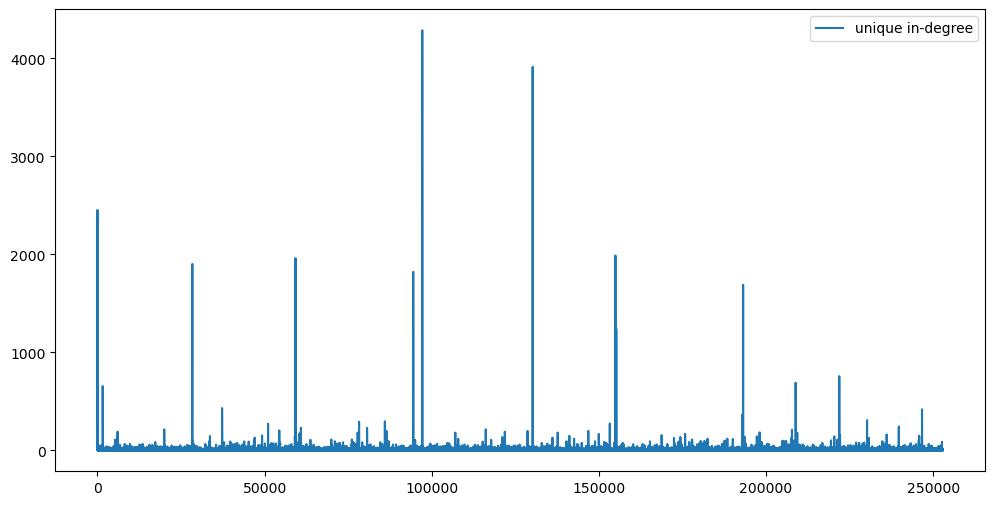

In [24]:
unique_in_df.plot(figsize=((12,6)))

In [25]:
sorted_in = unique_in_df.sort_values(by=['unique in-degree'], ascending=False).reset_index(drop=True)
sorted_in = sorted_in.groupby(['unique in-degree']).count().reset_index()
sorted_in = sorted_in.rename(columns={"address":"count"})
sorted_in

,unique in-degree,count
0,1,172114
1,2,37094
2,3,15924
3,4,8447
4,5,5065
...,...,...
151,1961,1
152,1988,1
153,2453,1
154,3913,1


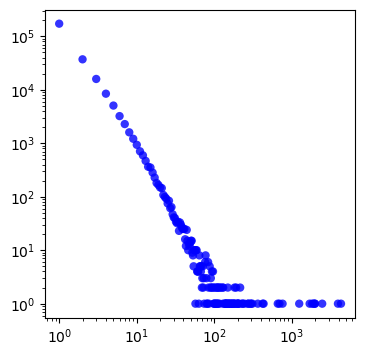

In [26]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_in['unique in-degree'] ,sorted_in['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

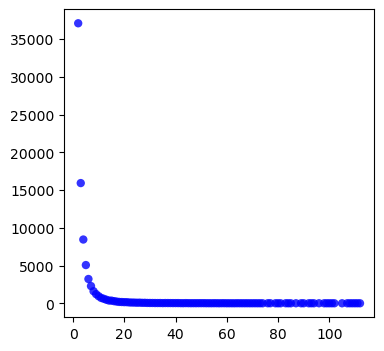

In [27]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_in.iloc[1:101]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['unique in-degree'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

### Unique In-Degree Ratio

In [14]:
unique_ratio_in = buys.merge(unique_in_df, how = 'left')
unique_ratio_in['unique-in ratio'] = unique_ratio_in['in-degree']/unique_ratio_in['unique in-degree']
unique_ratio_in = unique_ratio_in.drop(columns=['unique in-degree','in-degree'])
unique_ratio_in

,address,unique-in ratio
0,0x0000000000000000000000000000000000000001,20.500000
1,0x000000000000000000000000000000000000d3a0,15.000000
2,0x000000000000000000000000000000000000dead,2.644517
3,0x000000000000660def84e69995117c0176ba446e,1.000000
4,0x000000000000fd461ca2d54e8f4b3e37749df921,1.000000
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,1.000000
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,3.000000
252921,0xffff83075509851dca62ca604f191478ff041fd3,1.000000
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,10.000000


##### Vis & Analysis

In [15]:
unique_ratio_in.describe()

,unique-in ratio
count,252924.000000
mean,2.066819
std,12.088518
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5000.000000


In [16]:
sorted_ratio_in = unique_ratio_in[['address','unique-in ratio']].groupby(['unique-in ratio']).count().reset_index()
sorted_ratio_in = sorted_ratio_in.rename(columns={"address":"count"})
sorted_ratio_in

,unique-in ratio,count
0,1.000000,155452
1,1.018182,1
2,1.021277,1
3,1.021739,1
4,1.022727,2
...,...,...
1519,695.000000,1
1520,777.000000,1
1521,1158.000000,1
1522,1218.000000,1


In [17]:
sorted_ratio_in.describe()

,unique-in ratio,count
count,1524.000000,1524.000000
mean,25.610561,165.960630
std,147.087154,4117.225621
min,1.000000,1.000000
25%,1.653428,1.000000
50%,3.106203,1.000000
75%,10.578571,4.000000
max,5000.000000,155452.000000


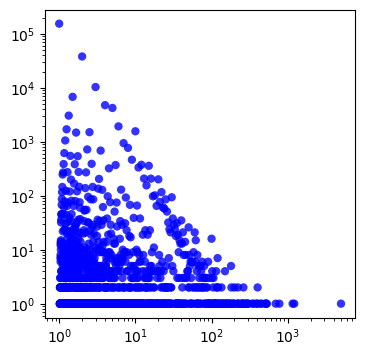

In [18]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_ratio_in['unique-in ratio'] ,sorted_ratio_in['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

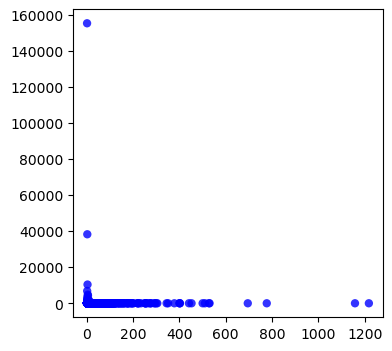

In [19]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_ratio_in.iloc[:-1]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['unique-in ratio'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

In [20]:
sorted_ratio_in_tenth = sorted_ratio_in
sorted_ratio_in_tenth['tenth'] = sorted_ratio_in_tenth['unique-in ratio']//10
sorted_ratio_in_tenth = sorted_ratio_in_tenth[['tenth','count']].groupby(['tenth']).sum().reset_index()
sorted_ratio_in_tenth = sorted_ratio_in_tenth.rename(columns={"count":"count"})
sorted_ratio_in_tenth.head()

,tenth,count
0,0.0,247364
1,1.0,3922
2,2.0,824
3,3.0,321
4,4.0,126


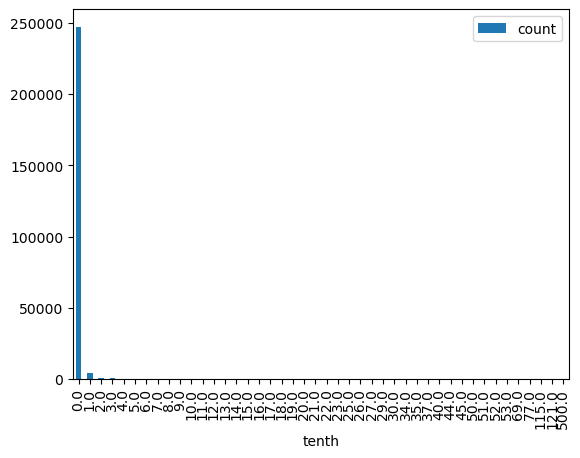

In [21]:
ax = sorted_ratio_in_tenth.plot.bar(x='tenth',y='count')

### Unique Out-Degree (total number of distinct buyers an account has interacted with)

In [22]:
unique_out_df = pd.read_sql_query("SELECT from_address as address,to_address as buyer from combined", conn)
unique_out_df = unique_out_df.drop_duplicates()
unique_out_df = df_wallets.merge(unique_out_df, how = 'left')
unique_out_df = unique_out_df.groupby(['address']).count()
unique_out_df = unique_out_df.rename(columns={'buyer':'unique out-degree'})
unique_out_df = unique_out_df.reset_index()
unique_out_df.head()

,address,unique out-degree
0,0x0000000000000000000000000000000000000001,0
1,0x000000000000000000000000000000000000d3a0,0
2,0x000000000000000000000000000000000000dead,0
3,0x000000000000660def84e69995117c0176ba446e,1
4,0x000000000000fd461ca2d54e8f4b3e37749df921,1


##### Vis & Analysis

In [36]:
print(unique_out_df.describe())
print("account number:",unique_out_df.shape[0])

       unique out-degree
count      252924.000000
mean            1.685194
std            11.516050
min             0.000000
25%             0.000000
50%             1.000000
75%             2.000000
max          3633.000000
account number: 252924


<AxesSubplot:>

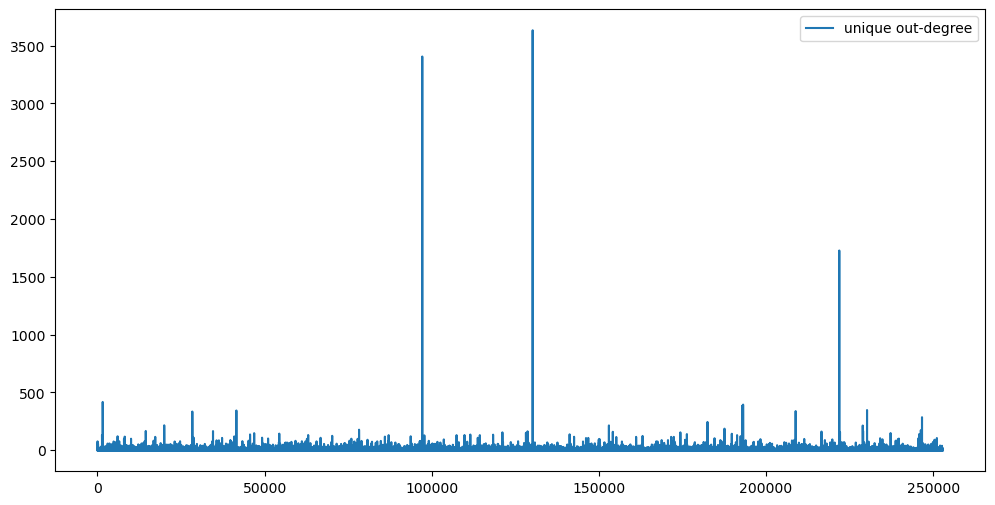

In [37]:
unique_out_df.plot(figsize=((12,6)))

In [38]:
sorted_out = unique_out_df.sort_values(by=['unique out-degree'], ascending=False).reset_index(drop=True)
sorted_out = sorted_out.groupby(['unique out-degree']).count().reset_index()
sorted_out = sorted_out.rename(columns={"address":"count"})
sorted_out

,unique out-degree,count
0,0,97940
1,1,88693
2,2,29004
3,3,11879
4,4,6778
...,...,...
149,395,1
150,418,1
151,1728,1
152,3406,1


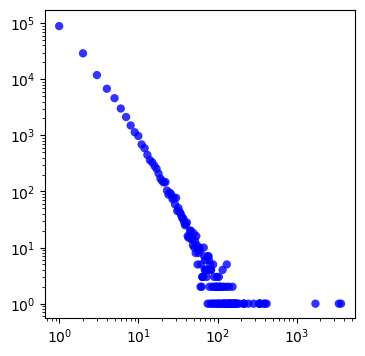

In [39]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_out['unique out-degree'] ,sorted_out['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

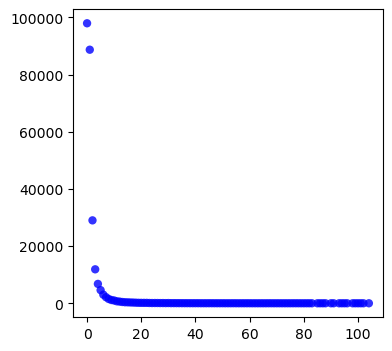

In [40]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_out.iloc[0:100]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['unique out-degree'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

### Unique Out-Degree Ratio

In [23]:
unique_ratio_out = sells.merge(unique_out_df, how = 'left')
unique_ratio_out['unique-out ratio'] = unique_ratio_out['out-degree']/unique_ratio_out['unique out-degree']
unique_ratio_out = unique_ratio_out.drop(columns=['unique out-degree','out-degree'])
unique_ratio_out = unique_ratio_out.fillna(0)
unique_ratio_out

,address,unique-out ratio
0,0x0000000000000000000000000000000000000001,0.0
1,0x000000000000000000000000000000000000d3a0,0.0
2,0x000000000000000000000000000000000000dead,0.0
3,0x000000000000660def84e69995117c0176ba446e,1.0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,2.0
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,0.0
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,0.0
252921,0xffff83075509851dca62ca604f191478ff041fd3,1.0
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,0.0


##### Vis & Analysis

In [24]:
unique_ratio_out.describe()

,unique-out ratio
count,252924.000000
mean,0.919961
std,10.482273
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,5129.000000


In [25]:
sorted_ratio_out = unique_ratio_out[['address','unique-out ratio']].groupby(['unique-out ratio']).count().reset_index()
sorted_ratio_out = sorted_ratio_out.rename(columns={"address":"count"})
sorted_ratio_out

,unique-out ratio,count
0,0.000000,97940
1,1.000000,115805
2,1.019231,1
3,1.020349,1
4,1.020408,1
...,...,...
1036,251.000000,1
1037,267.000000,1
1038,274.500000,1
1039,293.000000,1


In [26]:
sorted_ratio_out.describe()

,unique-out ratio,count
count,1041.000000,1041.000000
mean,14.641825,242.962536
std,161.063012,4719.401425
min,0.000000,1.000000
25%,1.282258,1.000000
50%,1.871795,1.000000
75%,4.705882,4.000000
max,5129.000000,115805.000000


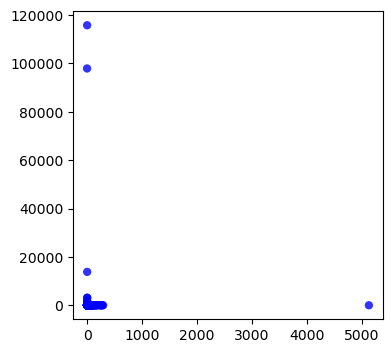

In [27]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_ratio_out['unique-out ratio'] ,sorted_ratio_out['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

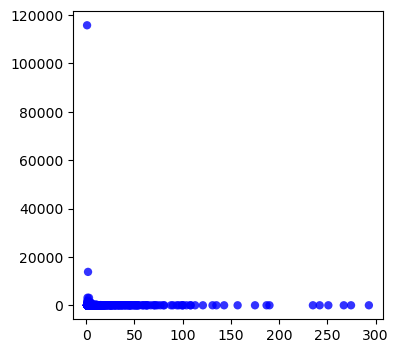

In [28]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_ratio_out.iloc[1:-1]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['unique-out ratio'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

In [29]:
sorted_ratio_out_tenth = sorted_ratio_out
sorted_ratio_out_tenth['tenth'] = sorted_ratio_out_tenth['unique-out ratio']*10//1
sorted_ratio_out_tenth = sorted_ratio_out_tenth[['tenth','count']].groupby(['tenth']).sum().reset_index()
sorted_ratio_out_tenth = sorted_ratio_out_tenth.rename(columns={"address":"count"})
sorted_ratio_out_tenth

,tenth,count
0,0.0,97940
1,10.0,116956
2,11.0,2362
3,12.0,2807
4,13.0,2318
...,...,...
237,2510.0,1
238,2670.0,1
239,2745.0,1
240,2930.0,1


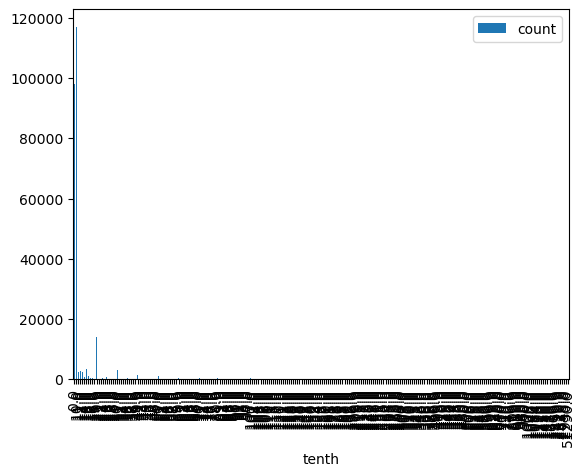

In [30]:
ax = sorted_ratio_out_tenth.plot.bar(x='tenth',y='count')

### Hold Ratio

In [41]:
in_out_ratio = buys.merge(sells)
# in_out_ratio['in-out ratio'] = 1-(in_out_ratio['out-degree']/in_out_ratio['in-degree'])
# in_out_ratio['in-out ratio'] = 1-(in_out_ratio['out-degree']/in_out_ratio['in-degree'])
in_out_ratio = in_out_ratio.drop(columns=['in-degree','out-degree'])
in_out_ratio

,address,in-out ratio
0,0x0000000000000000000000000000000000000001,1.0
1,0x000000000000000000000000000000000000d3a0,1.0
2,0x000000000000000000000000000000000000dead,1.0
3,0x000000000000660def84e69995117c0176ba446e,0.0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.0
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,1.0
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,1.0
252921,0xffff83075509851dca62ca604f191478ff041fd3,0.5
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,1.0


##### Vis & Analysis

In [49]:
in_out_ratio.describe()

,in-out ratio
count,252924.000000
mean,0.463754
std,0.464643
min,0.000000
25%,0.000000
50%,0.333333
75%,1.000000
max,1.000000


In [50]:
sorted_hold = in_out_ratio.groupby(['in-out ratio']).count().reset_index()
sorted_hold = sorted_hold.rename(columns={"address":"count"})
sorted_hold

,in-out ratio,count
0,0.000000,113676
1,0.001938,1
2,0.003922,1
3,0.005952,1
4,0.006061,1
...,...,...
1323,0.995495,1
1324,0.995556,1
1325,0.997403,1
1326,0.997653,1


In [51]:
sorted_hold.describe()

,in-out ratio,count
count,1328.000000,1328.000000
mean,0.511119,190.454819
std,0.318635,4130.677197
min,0.000000,1.000000
25%,0.220272,1.000000
50%,0.510004,1.000000
75%,0.811949,3.000000
max,1.000000,113676.000000


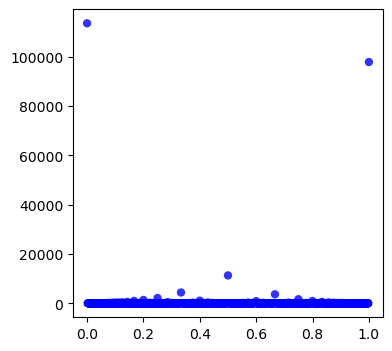

In [52]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_hold['in-out ratio'] ,sorted_hold['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

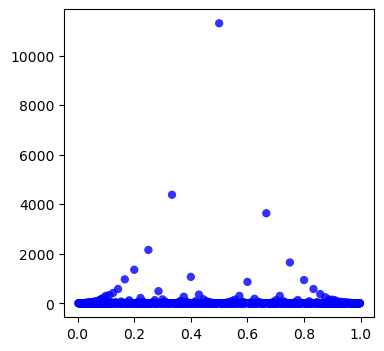

In [53]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_hold.iloc[1:-1]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['in-out ratio'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

In [54]:
sorted_hold_tenth = sorted_hold
sorted_hold_tenth['tenth'] = sorted_hold_tenth['in-out ratio']*10//1
sorted_hold_tenth = sorted_hold_tenth[['tenth','count']].groupby(['tenth']).sum().reset_index()
sorted_hold_tenth = sorted_hold_tenth.rename(columns={"address":"count"})
sorted_hold_tenth

,tenth,count
0,0.0,115558
1,1.0,4357
2,2.0,3521
3,3.0,5402
4,4.0,2157
5,5.0,12281
6,6.0,5155
7,7.0,2670
8,8.0,2797
9,9.0,1086


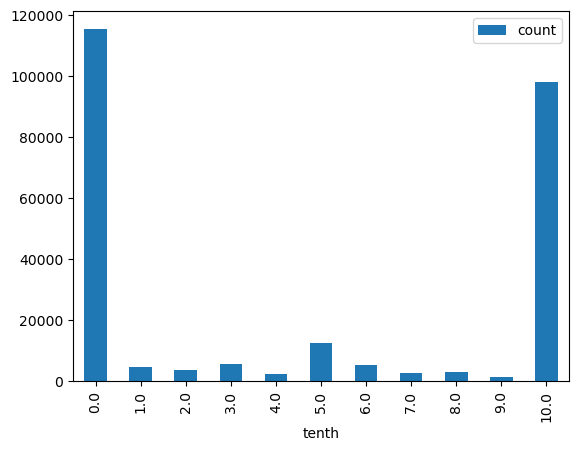

In [55]:
ax = sorted_hold_tenth.plot.bar(x='tenth',y='count')

### Network features combined

In [31]:
# network_features = buys.merge(sells).merge(unique_in_df).merge(unique_out_df).merge(unique_ratio_in).merge(unique_ratio_out).merge(in_out_ratio)
network_features = buys.merge(sells).merge(unique_ratio_in).merge(unique_ratio_out)
network_features.head()

,address,in-degree,out-degree,unique-in ratio,unique-out ratio
0,0x0000000000000000000000000000000000000001,41,0,20.500000,0.0
1,0x000000000000000000000000000000000000d3a0,15,0,15.000000,0.0
2,0x000000000000000000000000000000000000dead,6487,0,2.644517,0.0
3,0x000000000000660def84e69995117c0176ba446e,1,1,1.000000,1.0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,2,2,1.000000,2.0


In [40]:
network_features.to_sql("network_features", conn, if_exists='replace', index=False)

252924

In [32]:
print("account number:",network_features.shape[0])

account number: 252924


<AxesSubplot:>

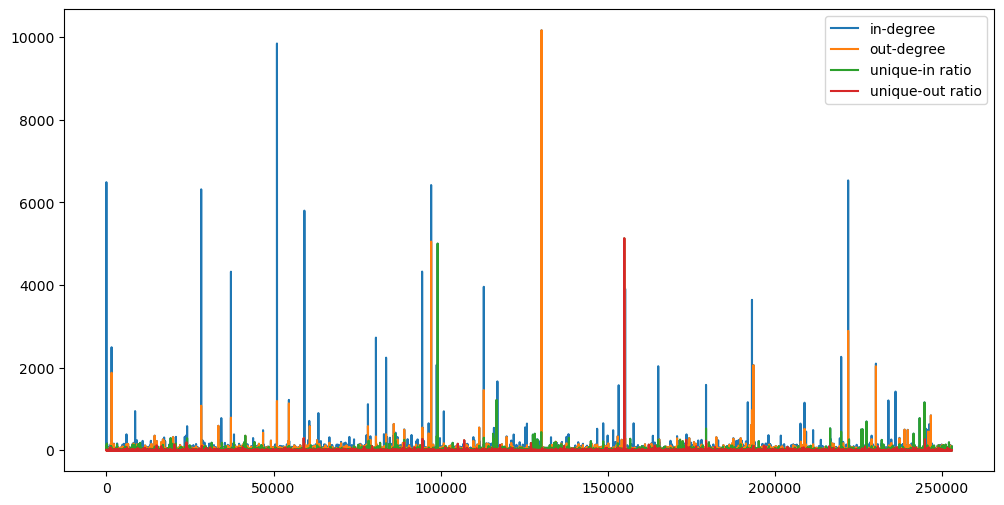

In [13]:
network_features.plot(figsize=((12,6)))

##### Vis & Analysis

<AxesSubplot:>

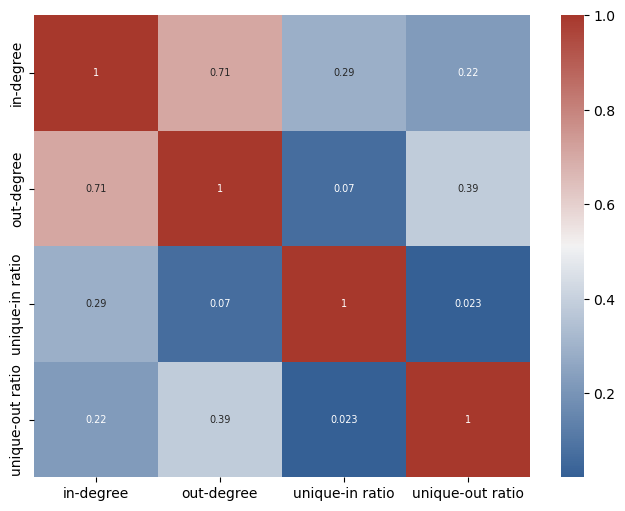

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cor = network_features.corr()
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize = (8,6))
sns.heatmap(cor,annot=True,annot_kws={"size": 7},cmap=cmap)

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = network_features[considered_features]
    X['intercept'] = 1
    
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = ['in-degree', 'out-degree','unique-in ratio','unique-out ratio']
compute_vif(considered_features)

,Variable,VIF
0,in-degree,2.287343
1,out-degree,2.351106
2,unique-in ratio,1.134038
3,unique-out ratio,1.182173


In [37]:
network_features.dtypes

address              object
in-degree             int64
out-degree            int64
unique-in ratio     float64
unique-out ratio    float64
dtype: object

In [38]:
def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()
    
    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Subset the matrix
    reduced_matrix = matrix.mask(mask)
    
    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]
    
    return to_drop

In [39]:
temp = network_features.drop(columns=['address'])
matrix = temp.corr().abs()
mask = np.triu(np.ones_like(matrix, dtype=bool))
reduced_matrix = matrix.mask(mask)
to_drop = identify_correlated(temp, threshold=.9)
print(to_drop)

[]


## Currency Features

### total In-transaction: total amount bought in usd

In [9]:
total_in = pd.read_sql_query("SELECT to_address as address, price from combined", conn)
total_in = df_wallets.merge(total_in, how = 'left')
total_in = total_in.fillna(0)
total_in = total_in.groupby(['address']).sum()
total_in = total_in.rename(columns={'price':'total in-transaction'})
total_in = total_in.reset_index()
total_in.head()

,address,total in-transaction
0,0x0000000000000000000000000000000000000001,0.000000e+00
1,0x000000000000000000000000000000000000d3a0,0.000000e+00
2,0x000000000000000000000000000000000000dead,0.000000e+00
3,0x000000000000660def84e69995117c0176ba446e,1.317993e-15
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.000000e+00


##### Vis & Analysis

In [65]:
print(total_in.describe())
print("account number:",total_in.shape[0])

       total in-transaction
count          2.529240e+05
mean           6.550466e+03
std            1.750891e+05
min            0.000000e+00
25%            0.000000e+00
50%            2.598067e+02
75%            1.428441e+03
max            5.933505e+07
account number: 252924


<AxesSubplot:>

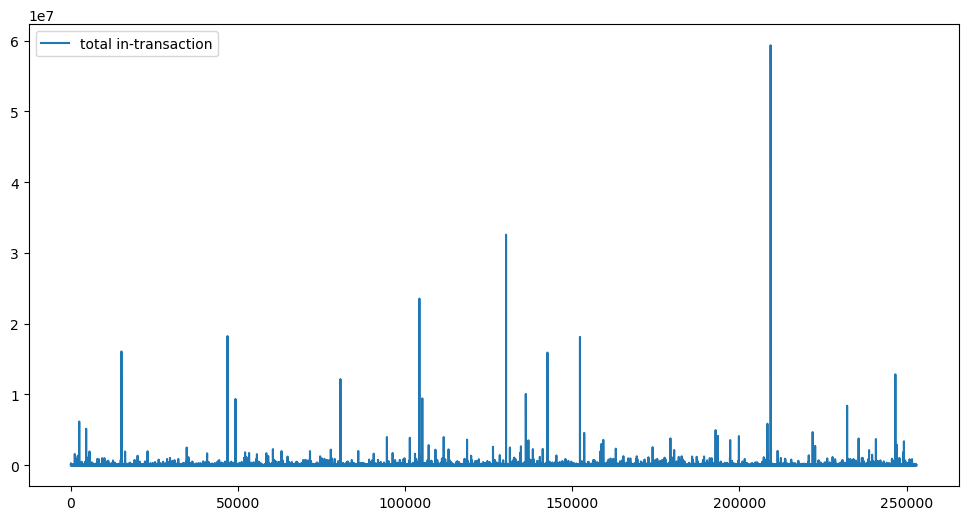

In [66]:
total_in.plot(figsize=((12,6)))

In [67]:
sorted_total_in = total_in.sort_values(by=['total in-transaction'], ascending=False).reset_index(drop=True)
sorted_total_in = sorted_total_in.groupby(['total in-transaction']).count().reset_index()
sorted_total_in = sorted_total_in.rename(columns={"address":"count"})
sorted_total_in

,total in-transaction,count
0,0.000000e+00,75824
1,1.317993e-15,1
2,1.580788e-15,1
3,1.662770e-15,1
4,4.005987e-15,1
...,...,...
100434,1.813464e+07,1
100435,1.825151e+07,1
100436,2.354431e+07,1
100437,3.257480e+07,1


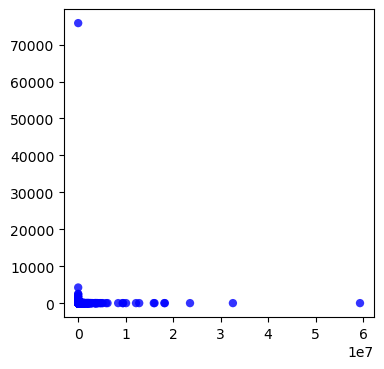

In [68]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_total_in['total in-transaction'] ,sorted_total_in['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

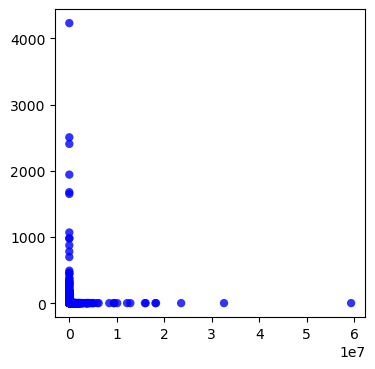

In [69]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_total_in.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['total in-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

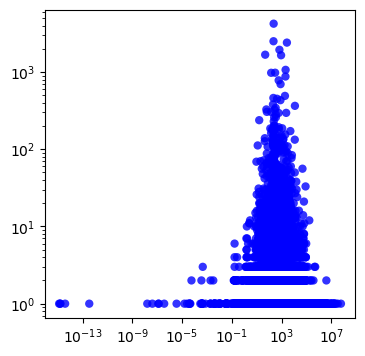

In [70]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_total_in.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['total in-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### total Out-transaction: total amount sold in usd

In [10]:
total_out = pd.read_sql_query("SELECT from_address as address, price from combined", conn)
total_out = df_wallets.merge(total_out, how = 'left')
total_out = total_out.fillna(0)
total_out = total_out.groupby(['address']).sum()
total_out = total_out.rename(columns={'price':'total out-transaction'})
total_out = total_out.reset_index()
total_out.head()

,address,total out-transaction
0,0x0000000000000000000000000000000000000001,0.000000e+00
1,0x000000000000000000000000000000000000d3a0,0.000000e+00
2,0x000000000000000000000000000000000000dead,0.000000e+00
3,0x000000000000660def84e69995117c0176ba446e,1.317993e-15
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.000000e+00


##### Vis & Analysis 

In [72]:
print(total_out.describe())
print("account number:",total_out.shape[0])

       total out-transaction
count           2.529240e+05
mean            4.646307e+03
std             9.398916e+04
min             0.000000e+00
25%             0.000000e+00
50%             0.000000e+00
75%             5.689928e+02
max             3.257480e+07
account number: 252924


<AxesSubplot:>

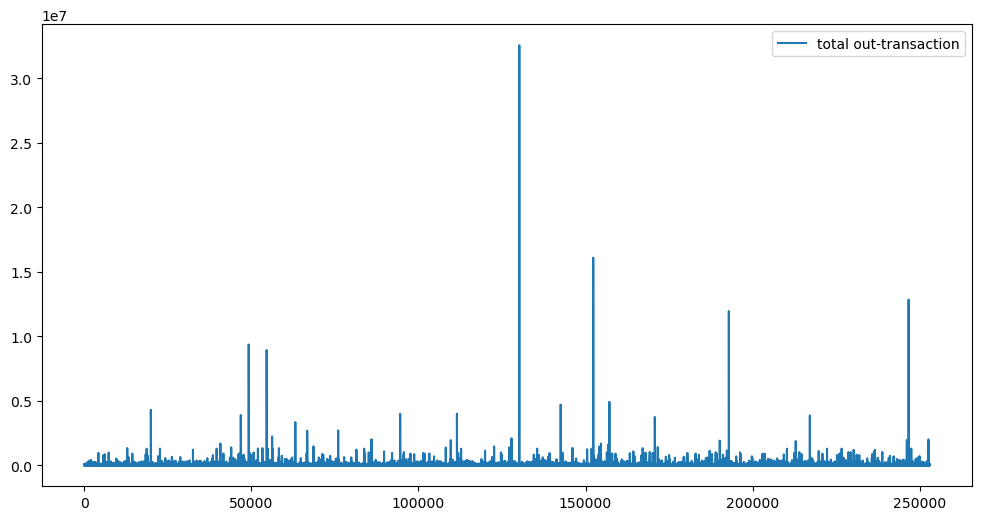

In [73]:
total_out.plot(figsize=((12,6)))

In [74]:
sorted_total_out = total_out.sort_values(by=['total out-transaction'], ascending=False).reset_index(drop=True)
sorted_total_out = sorted_total_out.groupby(['total out-transaction']).count().reset_index()
sorted_total_out = sorted_total_out.rename(columns={"address":"count"})
sorted_total_out

,total out-transaction,count
0,0.000000e+00,151140
1,1.317993e-15,1
2,1.580788e-15,1
3,4.005987e-15,1
4,3.486244e-13,2
...,...,...
81817,9.366360e+06,1
81818,1.196182e+07,1
81819,1.284646e+07,1
81820,1.609634e+07,1


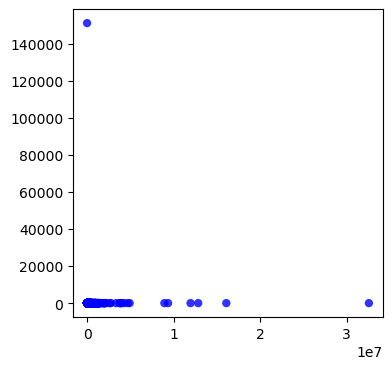

In [75]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_total_out['total out-transaction'] ,sorted_total_out['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

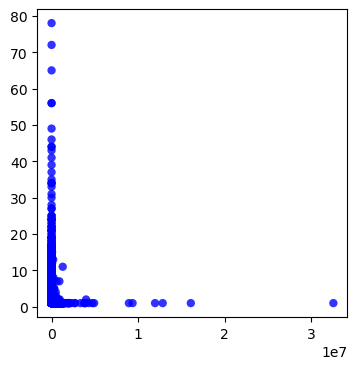

In [76]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_total_out.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['total out-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

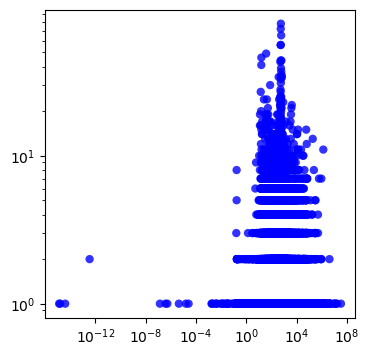

In [77]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_total_out.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['total out-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### average in-transaction: average amount bought in usd

In [11]:
average_in = pd.read_sql_query("SELECT to_address as address, price from combined", conn)
average_in = df_wallets.merge(average_in, how = 'left')
average_in = average_in.fillna(0)
average_in = average_in.groupby(['address']).mean()
average_in = average_in.rename(columns={'price':'average in-transaction'})
average_in = average_in.reset_index()
average_in.head()

,address,average in-transaction
0,0x0000000000000000000000000000000000000001,0.000000e+00
1,0x000000000000000000000000000000000000d3a0,0.000000e+00
2,0x000000000000000000000000000000000000dead,0.000000e+00
3,0x000000000000660def84e69995117c0176ba446e,1.317993e-15
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.000000e+00


##### Vis & Analysis

In [79]:
print(average_in.describe())
print("account number:",average_in.shape[0])

       average in-transaction
count           252924.000000
mean              1152.045299
std               6216.498847
min                  0.000000
25%                  0.000000
50%                187.880394
75%                571.004839
max             906731.751038
account number: 252924


<AxesSubplot:>

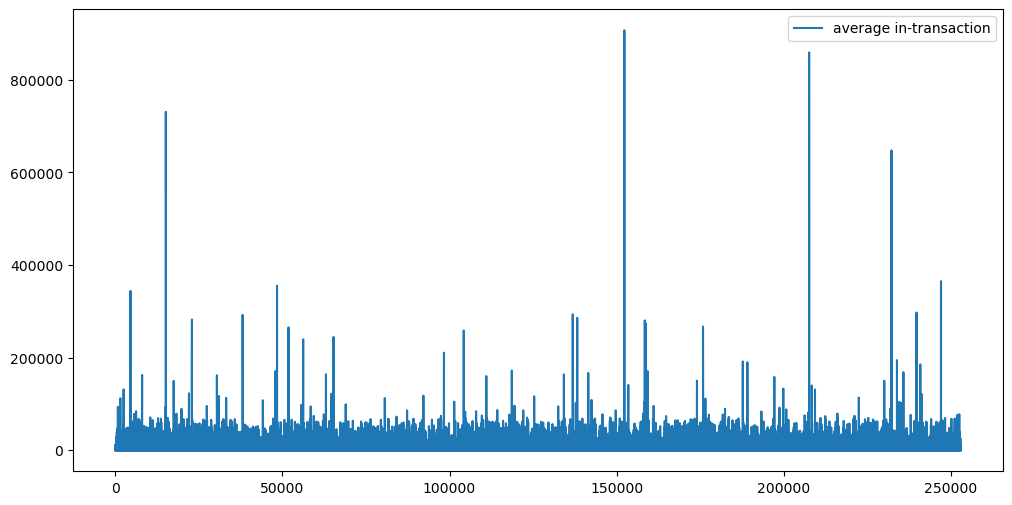

In [80]:
average_in.plot(figsize=((12,6)))

In [81]:
sorted_avg_in = average_in.sort_values(by=['average in-transaction'], ascending=False).reset_index(drop=True)
sorted_avg_in  = sorted_avg_in .groupby(['average in-transaction']).count().reset_index()
sorted_avg_in  = sorted_avg_in .rename(columns={"address":"count"})
sorted_avg_in 

,average in-transaction,count
0,0.000000e+00,75824
1,3.161576e-16,1
2,1.317993e-15,1
3,1.335329e-15,1
4,1.662770e-15,1
...,...,...
103678,3.651484e+05,1
103679,6.474076e+05,1
103680,7.307140e+05,1
103681,8.590482e+05,1


In [82]:
sorted_avg_in.describe()

,average in-transaction,count
count,103683.000000,103683.000000
mean,2303.351440,2.439397
std,9343.031753,236.269927
min,0.000000,1.000000
25%,145.639071,1.000000
50%,407.086123,1.000000
75%,1113.244729,1.000000
max,906731.751038,75824.000000


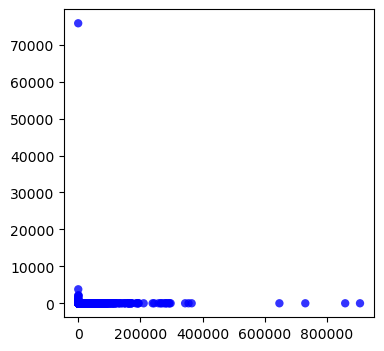

In [83]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_avg_in['average in-transaction'] ,sorted_avg_in['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

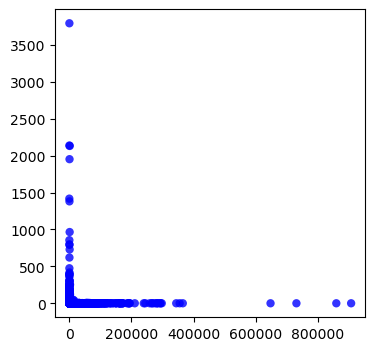

In [84]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_avg_in.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['average in-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

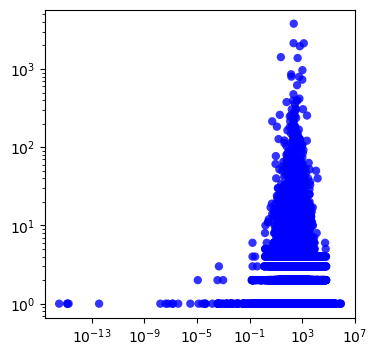

In [85]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_avg_in.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['average in-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### average out-transaction: average amount sold in usd

In [12]:
average_out = pd.read_sql_query("SELECT from_address as address, price from combined", conn)
average_out = df_wallets.merge(average_out, how = 'left')
average_out = average_out.fillna(0)
average_out = average_out.groupby(['address']).mean()
average_out = average_out.rename(columns={'price':'average out-transaction'})
average_out = average_out.reset_index()
average_out.head()

,address,average out-transaction
0,0x0000000000000000000000000000000000000001,0.000000e+00
1,0x000000000000000000000000000000000000d3a0,0.000000e+00
2,0x000000000000000000000000000000000000dead,0.000000e+00
3,0x000000000000660def84e69995117c0176ba446e,1.317993e-15
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.000000e+00


##### Vis & Analysis

In [87]:
print(average_out.describe())
print("account number:",average_out.shape[0])

       average out-transaction
count             2.529240e+05
mean              1.272757e+03
std               1.158747e+04
min               0.000000e+00
25%               0.000000e+00
50%               0.000000e+00
75%               2.902207e+02
max               1.289626e+06
account number: 252924


<AxesSubplot:>

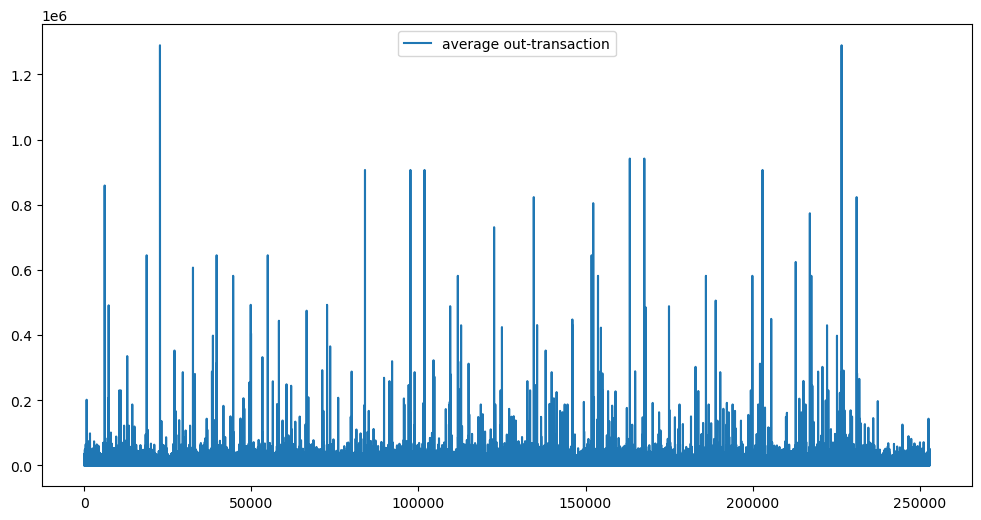

In [88]:
average_out.plot(figsize=((12,6)))

In [89]:
sorted_avg_out = average_out.sort_values(by=['average out-transaction'], ascending=False).reset_index(drop=True)
sorted_avg_out  = sorted_avg_out .groupby(['average out-transaction']).count().reset_index()
sorted_avg_out  = sorted_avg_out .rename(columns={"address":"count"})
sorted_avg_out 

,average out-transaction,count
0,0.000000e+00,151140
1,7.903940e-16,1
2,1.317993e-15,1
3,1.335329e-15,1
4,3.486244e-13,2
...,...,...
83128,8.233878e+05,2
83129,8.590482e+05,1
83130,9.067318e+05,4
83131,9.417724e+05,2


In [90]:
sorted_avg_out.describe()

,average out-transaction,count
count,8.313300e+04,83133.000000
mean,3.211737e+03,3.042402
std,1.594634e+04,524.191936
min,0.000000e+00,1.000000
25%,1.647274e+02,1.000000
50%,4.770097e+02,1.000000
75%,1.526056e+03,1.000000
max,1.289626e+06,151140.000000


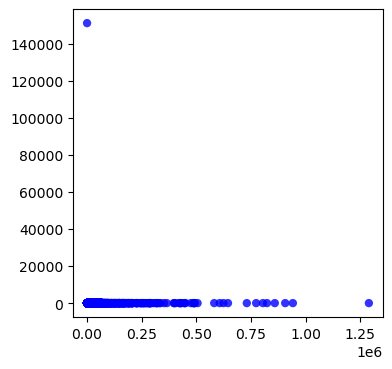

In [91]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_avg_out['average out-transaction'] ,sorted_avg_out['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

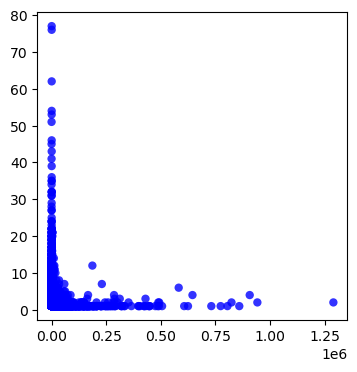

In [92]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_avg_out.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['average out-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

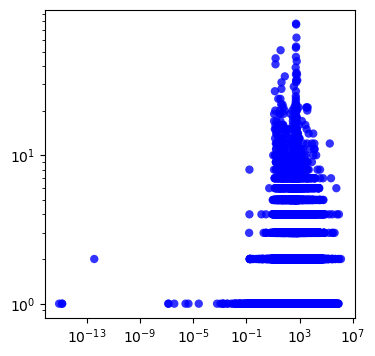

In [93]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_avg_out.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['average out-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### in-transaction standard deviation

In [13]:
std_in = pd.read_sql_query("SELECT to_address as address, price from combined", conn)
std_in = df_wallets.merge(std_in, how = 'left')
std_in = std_in.fillna(0)
std_in = std_in.groupby(['address']).std(ddof=0)
std_in = std_in.rename(columns={'price':'std in-transaction'})
std_in = std_in.reset_index()
std_in.head()

,address,std in-transaction
0,0x0000000000000000000000000000000000000001,0.0
1,0x000000000000000000000000000000000000d3a0,0.0
2,0x000000000000000000000000000000000000dead,0.0
3,0x000000000000660def84e69995117c0176ba446e,0.0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.0


##### Vis & Analysis

In [95]:
print(std_in.describe())
print("account number:",std_in.shape[0])

       std in-transaction
count       252924.000000
mean           444.702020
std           3049.101401
min              0.000000
25%              0.000000
50%              0.000000
75%             46.116625
max         420384.335113
account number: 252924


<AxesSubplot:>

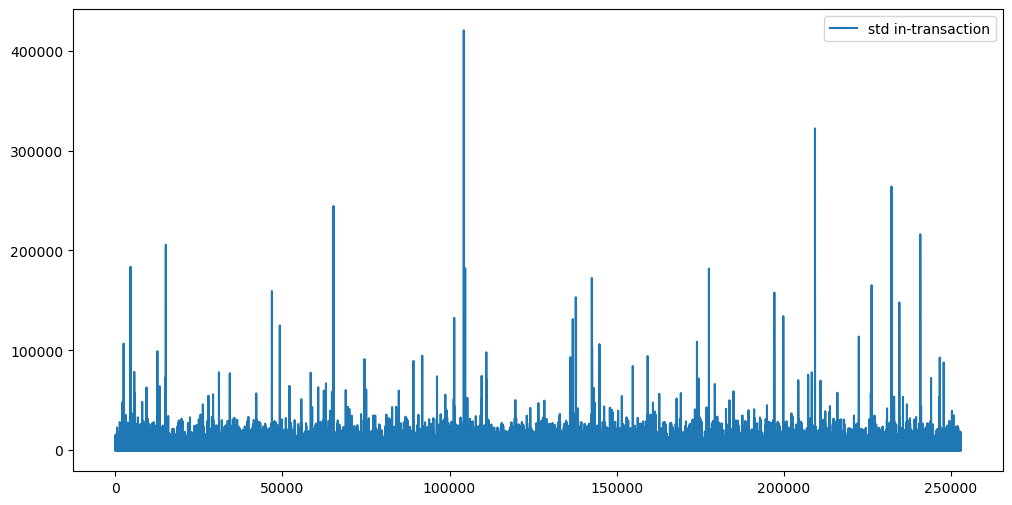

In [96]:
std_in.plot(figsize=((12,6)))

In [97]:
sorted_std_in = std_in.sort_values(by=['std in-transaction'], ascending=False).reset_index(drop=True)
sorted_std_in  = sorted_std_in.groupby(['std in-transaction']).count().reset_index()
sorted_std_in  = sorted_std_in.rename(columns={"address":"count"})
sorted_std_in

,std in-transaction,count
0,0.000000e+00,170033
1,6.323152e-16,1
2,8.469288e-12,1
3,4.367892e-09,1
4,6.887710e-09,1
...,...,...
74971,2.161530e+05,1
74972,2.444972e+05,1
74973,2.639703e+05,1
74974,3.221494e+05,1


In [98]:
sorted_std_in.describe()

,std in-transaction,count
count,74976.000000,74976.000000
mean,1467.458364,3.373399
std,5451.000756,620.970892
min,0.000000,1.000000
25%,53.396738,1.000000
50%,195.031617,1.000000
75%,651.829691,1.000000
max,420384.335113,170033.000000


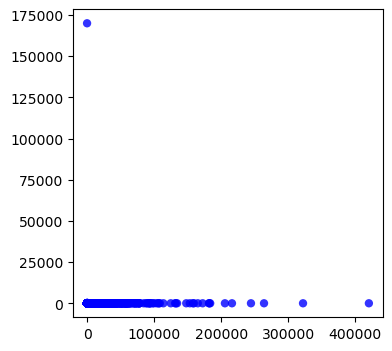

In [99]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_std_in['std in-transaction'] ,sorted_std_in['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

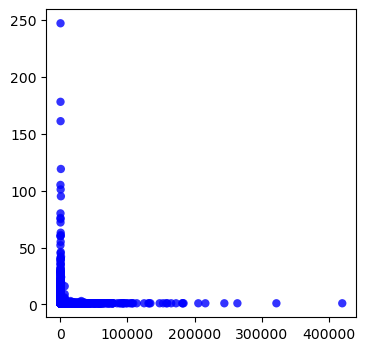

In [100]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_std_in.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['std in-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

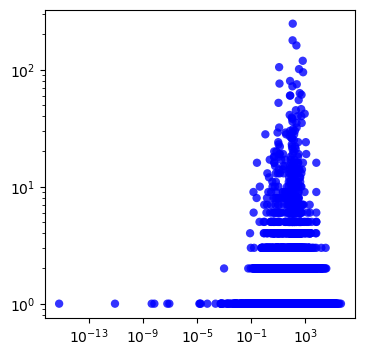

In [101]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_std_in.iloc[1:]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['std in-transaction'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### out-transaction standard deviation

In [14]:
std_out = pd.read_sql_query("SELECT from_address as address, price from combined", conn)
std_out = df_wallets.merge(std_out, how = 'left')
std_out = std_out.fillna(0)
std_out = std_out.groupby(['address']).std(ddof=0)
std_out = std_out.rename(columns={'price':'std out-transaction'})
std_out = std_out.reset_index()
std_out.head()

,address,std out-transaction
0,0x0000000000000000000000000000000000000001,0.0
1,0x000000000000000000000000000000000000d3a0,0.0
2,0x000000000000000000000000000000000000dead,0.0
3,0x000000000000660def84e69995117c0176ba446e,0.0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.0


##### Vis & Analysis

In [103]:
print(std_out.describe())
print("account number:",std_out.shape[0])

       std out-transaction
count        252924.000000
mean            689.861135
std            8557.648676
min               0.000000
25%               0.000000
50%               0.000000
75%               0.000000
max          644812.946407
account number: 252924


<AxesSubplot:>

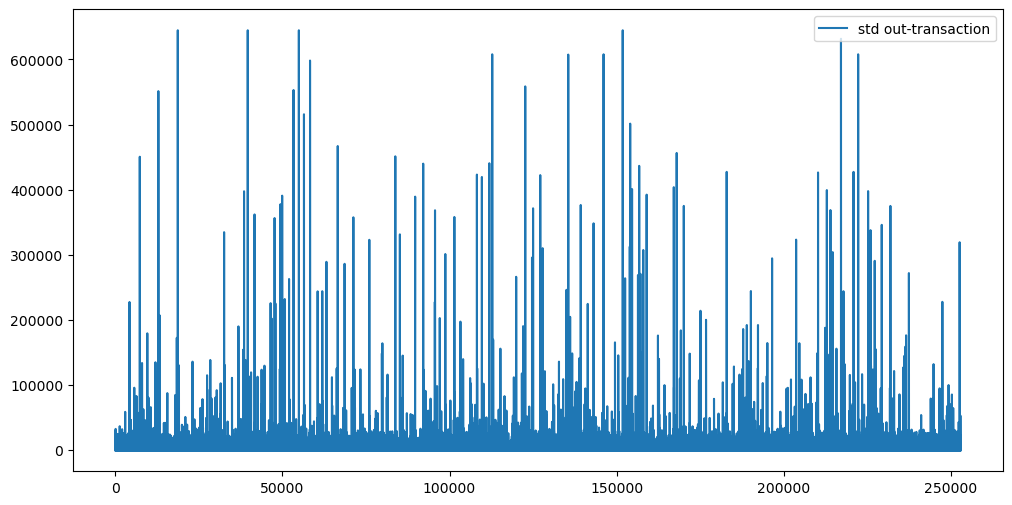

In [104]:
std_out.plot(figsize=((12,6)))

In [105]:
sorted_std_out = std_out.sort_values(by=['std out-transaction'], ascending=False).reset_index(drop=True)
sorted_std_out  = sorted_std_out.groupby(['std out-transaction']).count().reset_index()
sorted_std_out  = sorted_std_out.rename(columns={"address":"count"})
sorted_std_out

,std out-transaction,count
0,0.000000e+00,193875
1,7.903940e-16,1
2,3.581809e-09,1
3,9.389987e-08,1
4,6.818830e-07,1
...,...,...
57806,5.983242e+05,1
57807,6.074730e+05,1
57808,6.079355e+05,3
57809,6.317851e+05,1


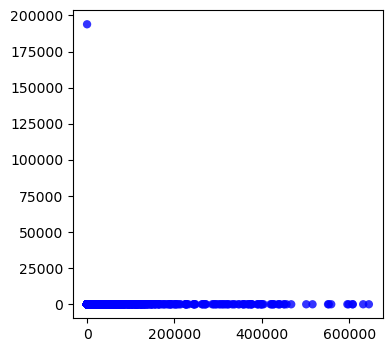

In [106]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_std_out['std out-transaction'] ,sorted_std_out['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

### Profit

In [107]:
def get_trans_profit(testing):
    record = df_all[(df_all['to_address'] == testing['address']) & (df_all['name'] == testing['name']) & (df_all['token_id'] == testing['token_id'])]
    record = record[['block_timestamp','price']]
    record['block_timestamp'] = pd.to_datetime(record['block_timestamp']).dt.strftime('%B %d, %Y, %r')
    record = record[record['block_timestamp'] < testing['block_timestamp']]
    record = record.sort_values(by=['block_timestamp'], ascending = False)
    profit = testing['price'] - record['price']
    return profit

In [15]:
trans_sells = pd.read_sql_query("SELECT block_timestamp, name, token_id, from_address, to_address, price from combined", conn)
trans_sells['block_timestamp'] = pd.to_datetime(trans_sells['block_timestamp'])
trans_sells_st = trans_sells.sort_values(by=['name','token_id','block_timestamp'])
trans_sells_st

,block_timestamp,name,token_id,from_address,to_address,price
458589,2021-12-18 18:40:23+00:00,8th Wonders by 8th Project,0,0x0000000000000000000000000000000000000000,0x627137fc6cfa3fbfa0ed936fb4b5d66fb383dbe8,0.000000
458588,2021-12-18 20:07:26+00:00,8th Wonders by 8th Project,1,0x0000000000000000000000000000000000000000,0xa696476c4bd332677c968b83d24b643e2d727b8c,396.086011
458579,2021-12-18 20:07:58+00:00,8th Wonders by 8th Project,10,0x0000000000000000000000000000000000000000,0x0e39baacc365f370af552a9bcda9e50f1f54dd63,990.215027
458489,2021-12-18 21:27:18+00:00,8th Wonders by 8th Project,100,0x0000000000000000000000000000000000000000,0x1eea95f2d2ed24cd3451da93a69efdd08767cc5b,0.000000
456752,2022-02-07 02:56:43+00:00,8th Wonders by 8th Project,100,0x1eea95f2d2ed24cd3451da93a69efdd08767cc5b,0x5723b3cdc1d72a03a19a5cf8efe5d3decbb2a317,0.000000
...,...,...,...,...,...,...
778002,2022-04-23 00:19:50+00:00,vSamurai Genesis,998,0x5808a0c2c10b9043c0dd3f1b3b733c406b363319,0xbd8a01f4426d7e5bdaeba7602009c47681fd3b3b,47.009824
779501,2022-04-22 23:42:55+00:00,vSamurai Genesis,999,0x0000000000000000000000000000000000000000,0x5808a0c2c10b9043c0dd3f1b3b733c406b363319,0.000000
778004,2022-04-23 00:19:10+00:00,vSamurai Genesis,999,0x5808a0c2c10b9043c0dd3f1b3b733c406b363319,0xd8874d84e9d415989dd10c6dffc82bc65fdcf725,44.071710
775093,2022-05-23 14:47:54+00:00,vSamurai Genesis,999,0xd8874d84e9d415989dd10c6dffc82bc65fdcf725,0x3d809be8fd3477251561625a4ae9f3b356f4d92a,78.887275


In [16]:
prev_name = trans_sells_st.iloc[0]['name']
prev_token = trans_sells.iloc[0]['token_id']
prev_price = 0
count = 0

res_profit = []
res_profit_ratio = []

for index, row in trans_sells_st.iterrows():
    if row['name'] == prev_name and row['token_id'] == prev_token:
        count += 1
    else:
        count = 1
        prev_name = row['name']
        prev_token = row['token_id']
    if count == 1:
        res_profit.append(0)
        res_profit_ratio.append(0)
    else:
        if prev_price == 0:
            res_profit.append(row['price'] - prev_price)
            res_profit_ratio.append(0)
        else:
            res_profit_ratio.append((row['price'] - prev_price)/prev_price)
            res_profit.append(0)
    prev_price = row['price']


trans_sells_st['profit'] = res_profit
trans_sells_st['profit-ratio'] = res_profit_ratio
trans_sells_st

,block_timestamp,name,token_id,from_address,to_address,price,profit,profit-ratio
458589,2021-12-18 18:40:23+00:00,8th Wonders by 8th Project,0,0x0000000000000000000000000000000000000000,0x627137fc6cfa3fbfa0ed936fb4b5d66fb383dbe8,0.000000,0.000000,0.000000
458588,2021-12-18 20:07:26+00:00,8th Wonders by 8th Project,1,0x0000000000000000000000000000000000000000,0xa696476c4bd332677c968b83d24b643e2d727b8c,396.086011,0.000000,0.000000
458579,2021-12-18 20:07:58+00:00,8th Wonders by 8th Project,10,0x0000000000000000000000000000000000000000,0x0e39baacc365f370af552a9bcda9e50f1f54dd63,990.215027,0.000000,0.000000
458489,2021-12-18 21:27:18+00:00,8th Wonders by 8th Project,100,0x0000000000000000000000000000000000000000,0x1eea95f2d2ed24cd3451da93a69efdd08767cc5b,0.000000,0.000000,0.000000
456752,2022-02-07 02:56:43+00:00,8th Wonders by 8th Project,100,0x1eea95f2d2ed24cd3451da93a69efdd08767cc5b,0x5723b3cdc1d72a03a19a5cf8efe5d3decbb2a317,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
778002,2022-04-23 00:19:50+00:00,vSamurai Genesis,998,0x5808a0c2c10b9043c0dd3f1b3b733c406b363319,0xbd8a01f4426d7e5bdaeba7602009c47681fd3b3b,47.009824,47.009824,0.000000
779501,2022-04-22 23:42:55+00:00,vSamurai Genesis,999,0x0000000000000000000000000000000000000000,0x5808a0c2c10b9043c0dd3f1b3b733c406b363319,0.000000,0.000000,0.000000
778004,2022-04-23 00:19:10+00:00,vSamurai Genesis,999,0x5808a0c2c10b9043c0dd3f1b3b733c406b363319,0xd8874d84e9d415989dd10c6dffc82bc65fdcf725,44.071710,44.071710,0.000000
775093,2022-05-23 14:47:54+00:00,vSamurai Genesis,999,0xd8874d84e9d415989dd10c6dffc82bc65fdcf725,0x3d809be8fd3477251561625a4ae9f3b356f4d92a,78.887275,0.000000,0.789975


#### Profit-from-zero

In [17]:
df_profit = trans_sells_st[['from_address','profit']]
df_profit = df_profit.groupby(['from_address']).mean().reset_index()
df_profit = df_profit.rename(columns={"profit":"profit-from-zero"})
df_profit = df_wallets.merge(df_profit,how='left',left_on='address', right_on='from_address')
df_profit = df_profit.drop(columns=['from_address'])
df_profit = df_profit.fillna(0)

df_profit.head()

,address,profit-from-zero
0,0x744a1ee51766d9d30229a46b62ef84a8a481470f,0.000000
1,0x5df4660295bed7abc783480c7d28d8c015cfb37a,85.568502
2,0x3d41199226f984505d7be029057c23be4a44795e,468.983136
3,0x543154e6914d93a137b0749d2e6432a4d597df49,38.753141
4,0xb240163d43e29e2d1f5b7c00e0f6da0f2b7ca79d,0.000000


In [18]:
df_profit_ratio = trans_sells_st[['from_address','profit-ratio']]
df_profit_ratio = df_profit_ratio.groupby(['from_address']).mean().reset_index()
df_profit_ratio = df_profit_ratio.rename(columns={"profit-ratio":"profit-ratio"})
df_profit_ratio = df_wallets.merge(df_profit_ratio,how='left',left_on='address', right_on='from_address')
df_profit_ratio = df_profit_ratio.drop(columns=['from_address'])
df_profit_ratio = df_profit_ratio.fillna(0)

df_profit_ratio.head()

,address,profit-ratio
0,0x744a1ee51766d9d30229a46b62ef84a8a481470f,0.000000
1,0x5df4660295bed7abc783480c7d28d8c015cfb37a,0.000000
2,0x3d41199226f984505d7be029057c23be4a44795e,0.000000
3,0x543154e6914d93a137b0749d2e6432a4d597df49,-0.066218
4,0xb240163d43e29e2d1f5b7c00e0f6da0f2b7ca79d,-1.000000


In [61]:
df_profit_ratio[df_profit_ratio['profit-ratio'] < -1]

,address,profit-ratio


##### Vis & Analysis

In [113]:
print(df_profit.describe())
print("account number:",df_profit.shape[0])

       profit-from-zero
count      2.529240e+05
mean       5.087095e+02
std        7.787171e+03
min        0.000000e+00
25%        0.000000e+00
50%        0.000000e+00
75%        0.000000e+00
max        1.289626e+06
account number: 252924


In [114]:
print(df_profit_ratio.describe())
print("account number:",df_profit_ratio.shape[0])

       profit-ratio
count  2.529240e+05
mean   3.645364e+11
std    1.833310e+14
min   -1.000000e+00
25%   -3.892729e-02
50%    0.000000e+00
75%    0.000000e+00
max    9.220000e+16
account number: 252924


<AxesSubplot:>

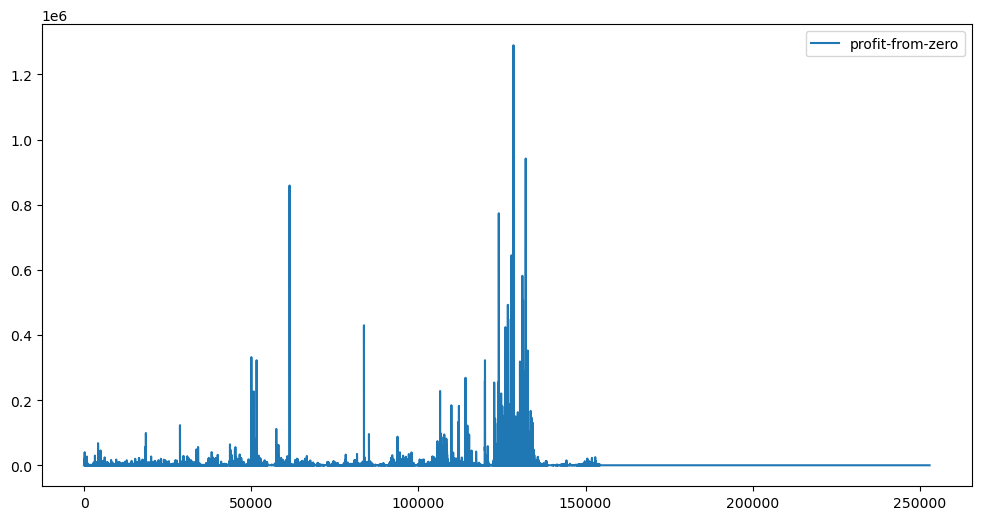

In [115]:
df_profit.plot(figsize=((12,6)))

<AxesSubplot:>

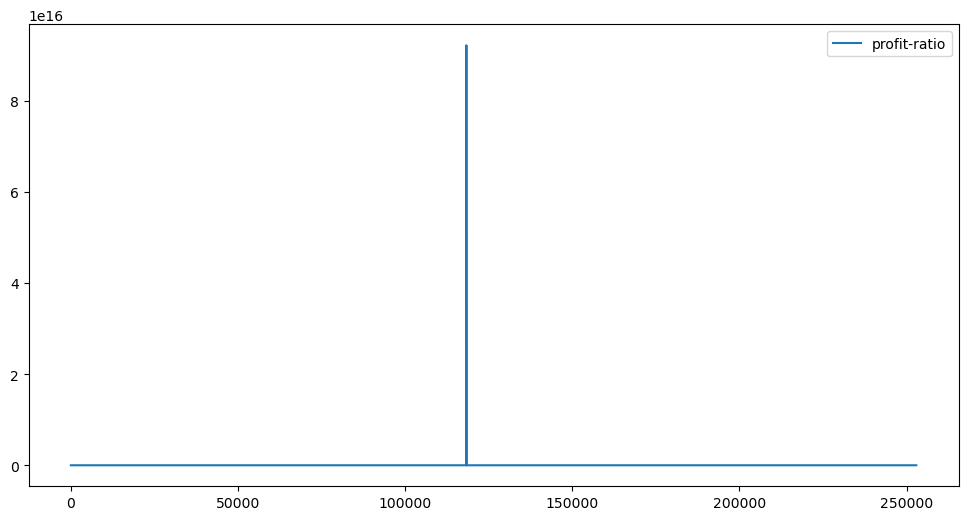

In [116]:
df_profit_ratio.plot(figsize=((12,6)))

In [117]:
sorted_profit = df_profit.sort_values(by=['profit-from-zero'], ascending=False).reset_index(drop=True)
sorted_profit = sorted_profit.groupby(['profit-from-zero']).count().reset_index()
sorted_profit = sorted_profit.rename(columns={"address":"count"})
sorted_profit

,profit-from-zero,count
0,0.000000e+00,215064
1,7.903940e-16,1
2,3.486244e-13,1
3,1.314647e-07,1
4,1.097237e-03,1
...,...,...
33625,8.233878e+05,1
33626,8.590482e+05,1
33627,9.067318e+05,1
33628,9.417724e+05,1


In [118]:
sorted_profit_ratio = df_profit_ratio.sort_values(by=['profit-ratio'], ascending=False).reset_index(drop=True)
sorted_profit_ratio = sorted_profit_ratio.groupby(['profit-ratio']).count().reset_index()
sorted_profit_ratio = sorted_profit_ratio.rename(columns={"address":"count"})
sorted_profit_ratio

,profit-ratio,count
0,-1.000000e+00,26498
1,-1.000000e+00,1
2,-1.000000e+00,1
3,-1.000000e+00,1
4,-1.000000e+00,1
...,...,...
70402,6.810535e+05,1
70403,1.277949e+06,1
70404,1.118833e+07,1
70405,1.998803e+08,1


In [119]:
sorted_profit_ratio.describe()

,profit-ratio,count
count,7.040700e+04,70407.000000
mean,1.309529e+12,3.592313
std,3.474746e+14,555.360134
min,-1.000000e+00,1.000000
25%,-3.393608e-01,1.000000
50%,9.952021e-02,1.000000
75%,1.053096e+00,1.000000
max,9.220000e+16,144933.000000


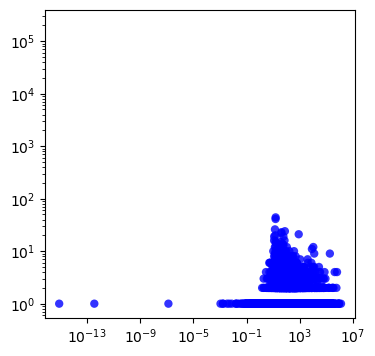

In [120]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_profit['profit-from-zero'] ,sorted_profit['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

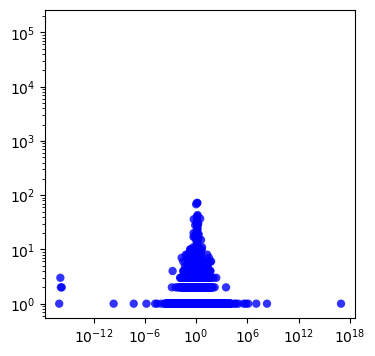

In [121]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_profit_ratio['profit-ratio'] ,sorted_profit_ratio['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

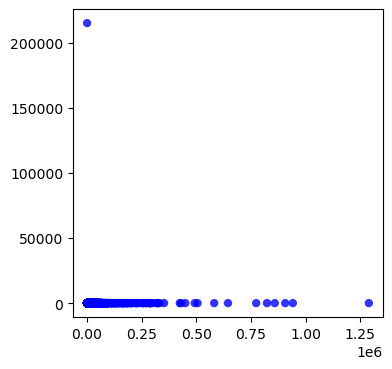

In [122]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_profit['profit-from-zero'] ,sorted_profit['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

### Transfer Ratio

In [19]:
transfer_ratio_1 = pd.read_sql_query("SELECT to_address as address, price from combined", conn)
transfer_ratio_2 = pd.read_sql_query("SELECT from_address as address, price from combined", conn)
transfer_ratio = pd.concat([transfer_ratio_1,transfer_ratio_2])
transfer_ratio = transfer_ratio[transfer_ratio['address'] != '0x0000000000000000000000000000000000000000']
transfers = transfer_ratio[transfer_ratio['price'] == 0]
transfers = transfers.groupby(['address']).count().reset_index()
transfers = transfers.rename(columns={"price":"transfers"})
total = transfer_ratio.groupby(['address']).count().reset_index()
total = total.rename(columns={"price":"total_trans"})
transfer_ratio = transfers.merge(total,how="outer")
# transfer_ratio['transfer-ratio'] = transfer_ratio['transfers']/transfer_ratio['total_trans']
transfer_ratio['transfer-num'] = transfer_ratio['transfers']
transfer_ratio = transfer_ratio.fillna(0)
transfer_ratio = transfer_ratio.drop(columns=['transfers','total_trans'])
print(transfer_ratio.shape[0])
transfer_ratio

252925


,address,transfer-num
0,0x0000000000000000000000000000000000000001,41.0
1,0x000000000000000000000000000000000000d3a0,15.0
2,0x000000000000000000000000000000000000dead,6487.0
3,0x000000000000fd461ca2d54e8f4b3e37749df921,4.0
4,0x000000000004d7463d0f9c77383600bc82d612f5,2.0
...,...,...
252920,0xfffe1eedf895d99cb7b3294e1e1f0251cad7a9a5,0.0
252921,0xfffed17fa03f91fe7e9042b248df6dceee1267df,0.0
252922,0xfffed4cfcaa4fb630594f0eef5f28c72c58c85cf,0.0
252923,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,0.0


##### Vis & Analysis

In [69]:
print(transfer_ratio.describe())

        transfer-num
count  252925.000000
mean        2.637367
std        54.567988
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max     11468.000000


In [72]:
sorted_tr = transfer_ratio.sort_values(by=['transfer-num'], ascending=False).reset_index(drop=True)
# sorted_tr = sorted_tr.groupby(['transfer-num']).count().reset_index()
# sorted_tr = sorted_tr.rename(columns={"address":"count"})
sorted_tr.head(20)

,address,transfer-num
0,0x620b70123fb810f6c653da7644b5dd0b6312e4d8,11468.0
1,0x9cd94694163ea05bdc630d16e843f574aba02245,10258.0
2,0x335a46e5de67986e2f0f251e00acd605b3c9a691,10005.0
3,0xe052113bd7d7700d623414a0a4585bcae754e9d5,9014.0
4,0x1c579006cd499871ac39aa2bf787462de603936c,7393.0
5,0x000000000000000000000000000000000000dead,6487.0
6,0x3bc4af76990a1e64fed1a22ab72242e7cd2d40d9,5965.0
7,0x255fcbadead80945b733ff6040c466fed277b8db,5112.0
8,0x640f4bb7a5a8ecac6eaf31d63857a4f4a962a62e,5087.0
9,0xc3503192343eae4b435e4a1211c5d28bf6f6a696,4610.0


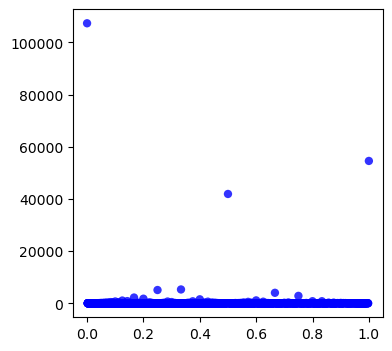

In [126]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_tr['transfer-ratio'] ,sorted_tr['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

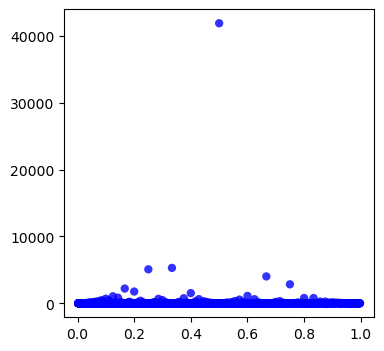

In [127]:
# plotting 100 samples that shouldn't be that skewed
sample = sorted_tr.iloc[1:-1]
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sample['transfer-ratio'] ,sample['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

In [128]:
sorted_tr_tenth = sorted_tr
sorted_tr_tenth['tenth'] = sorted_tr_tenth['transfer-ratio']*10//1
sorted_tr_tenth = sorted_tr_tenth[['tenth','count']].groupby(['tenth']).sum().reset_index()
sorted_tr_tenth = sorted_tr_tenth.rename(columns={"address":"count"})
sorted_tr_tenth

,tenth,count
0,0.0,111313
1,1.0,7080
2,2.0,9457
3,3.0,8083
4,4.0,4130
5,5.0,44354
6,6.0,6548
7,7.0,4031
8,8.0,2624
9,9.0,753


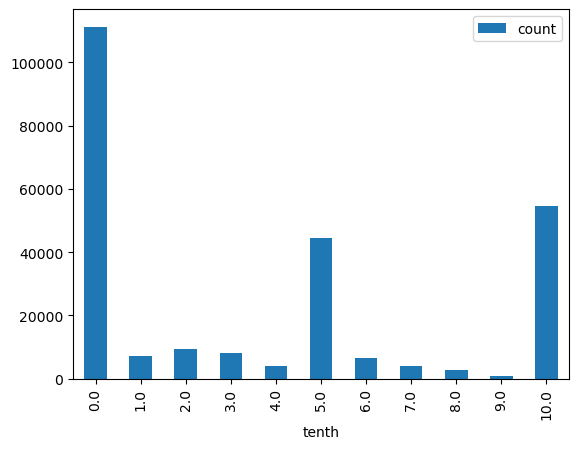

In [129]:
ax = sorted_tr_tenth.plot.bar(x='tenth',y='count')

### Relative-Sell

In [43]:
collection_item_price = pd.read_sql_query("SELECT name, block_timestamp as time, price from combined", conn)
collection_item_price['time'] = pd.to_datetime(collection_item_price['time']).dt.strftime('%Y-%m-%d')
collection_item_price = collection_item_price[collection_item_price['price'] != 0]
collection_item_price

,name,time,price
7,CryptoSpells,2022-09-05,468.983136
8,CryptoSpells,2022-08-29,170.834109
9,CryptoSpells,2022-08-29,170.834109
10,CryptoSpells,2022-08-29,170.834109
11,CryptoSpells,2022-08-29,170.834109
...,...,...,...
1137191,Animal Society,2021-10-20,623.398828
1137192,Animal Society,2021-10-20,623.398828
1137193,Animal Society,2021-10-20,623.398828
1137194,Animal Society,2021-10-20,623.398828


In [44]:
grouped_collection_item = collection_item_price.groupby(['name','time']).mean().reset_index()
grouped_collection_item = grouped_collection_item.rename(columns={"price":'price'})
grouped_collection_item

,name,time,price
0,8th Wonders by 8th Project,2021-12-18,996.355895
1,8th Wonders by 8th Project,2021-12-19,571.577769
2,8th Wonders by 8th Project,2021-12-20,821.653932
3,8th Wonders by 8th Project,2021-12-21,1293.375078
4,8th Wonders by 8th Project,2021-12-22,895.972412
...,...,...,...
13001,vSamurai Genesis,2022-07-31,42.037933
13002,vSamurai Genesis,2022-08-04,40.205145
13003,vSamurai Genesis,2022-08-05,34.298642
13004,vSamurai Genesis,2022-09-04,47.329248


In [45]:
grouped = grouped_collection_item.groupby(['name'])
ema = []
for name,group in grouped:
    prices = group['price'].to_frame()
    prices['EMA7'] = prices['price'].rolling(window=7, min_periods=1).mean()
    ema.append(prices['EMA7'].to_list())
flat_ema = [item for sublist in ema for item in sublist]

In [46]:
grouped_collection_item['EMA7'] = flat_ema
grouped_collection_item = grouped_collection_item.drop(columns=['price'])
grouped_collection_item

,name,time,EMA7
0,8th Wonders by 8th Project,2021-12-18,996.355895
1,8th Wonders by 8th Project,2021-12-19,783.966832
2,8th Wonders by 8th Project,2021-12-20,796.529199
3,8th Wonders by 8th Project,2021-12-21,920.740668
4,8th Wonders by 8th Project,2021-12-22,915.787017
...,...,...,...
13001,vSamurai Genesis,2022-07-31,116.060637
13002,vSamurai Genesis,2022-08-04,111.379996
13003,vSamurai Genesis,2022-08-05,105.078708
13004,vSamurai Genesis,2022-09-04,41.520894


In [47]:
sample = grouped_collection_item[grouped_collection_item['name'] == 'Doodles']
sample

,name,time,EMA7
2456,Doodles,2021-10-17,2628.200667
2457,Doodles,2021-10-18,3429.515816
2458,Doodles,2021-10-19,3602.192206
2459,Doodles,2021-10-20,3935.672791
2460,Doodles,2021-10-21,4077.018620
...,...,...,...
2807,Doodles,2022-10-03,16720.815610
2808,Doodles,2022-10-04,15874.123851
2809,Doodles,2022-10-05,15599.841647
2810,Doodles,2022-10-06,14793.048684


<AxesSubplot:xlabel='time'>

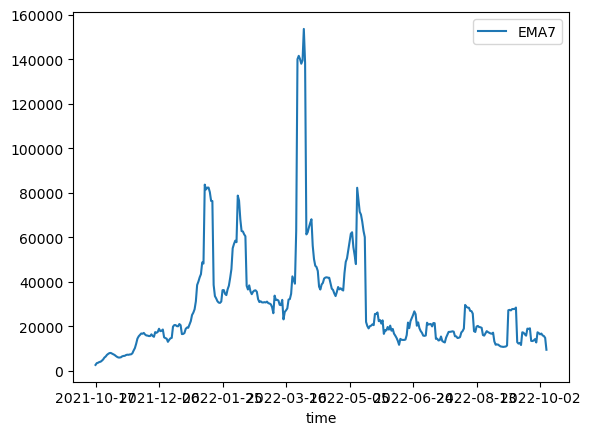

In [48]:
sample.plot(x='time',y='EMA7')

In [49]:
relative_sells = pd.read_sql_query("SELECT name, block_timestamp as time, price, from_address as address from combined", conn)
relative_sells['time'] = pd.to_datetime(relative_sells['time']).dt.strftime('%Y-%m-%d')
relative_sells = relative_sells.merge(grouped_collection_item, how='left', on=['name','time'])
relative_sells = relative_sells[relative_sells['address'] != '0x0000000000000000000000000000000000000000']
relative_sells = relative_sells[relative_sells['price'] != 0]
relative_sells['relative-sell'] = (relative_sells['price'] - relative_sells['EMA7'])/relative_sells['EMA7']
relative_sells = relative_sells[['address','relative-sell']].groupby(['address']).mean().reset_index()
relative_sells = df_wallets.merge(relative_sells,how='left')
relative_sells = relative_sells.fillna(0)
relative_sells

,address,relative-sell
0,0x744a1ee51766d9d30229a46b62ef84a8a481470f,0.000000
1,0x5df4660295bed7abc783480c7d28d8c015cfb37a,0.273591
2,0x3d41199226f984505d7be029057c23be4a44795e,0.683603
3,0x543154e6914d93a137b0749d2e6432a4d597df49,-0.312135
4,0xb240163d43e29e2d1f5b7c00e0f6da0f2b7ca79d,0.000000
...,...,...
252919,0x6bf8ee9de4a4876cf5b88fcd5bb343e6871bae4a,0.000000
252920,0x6ef8c88e31f36b99afd4584e25d4f69b0793187b,0.000000
252921,0xb2067abf5f1eb2e748ccbac4127b70c2ef90f202,0.000000
252922,0x4fc6c7c10410d54e20f041475fb50be535d7ec76,0.000000


##### Vis & Analysis

In [50]:
relative_sells.describe()

,relative-sell
count,252924.000000
mean,0.093019
std,1.278311
min,-1.000000
25%,-0.044915
50%,0.000000
75%,0.000000
max,117.549533


<AxesSubplot:>

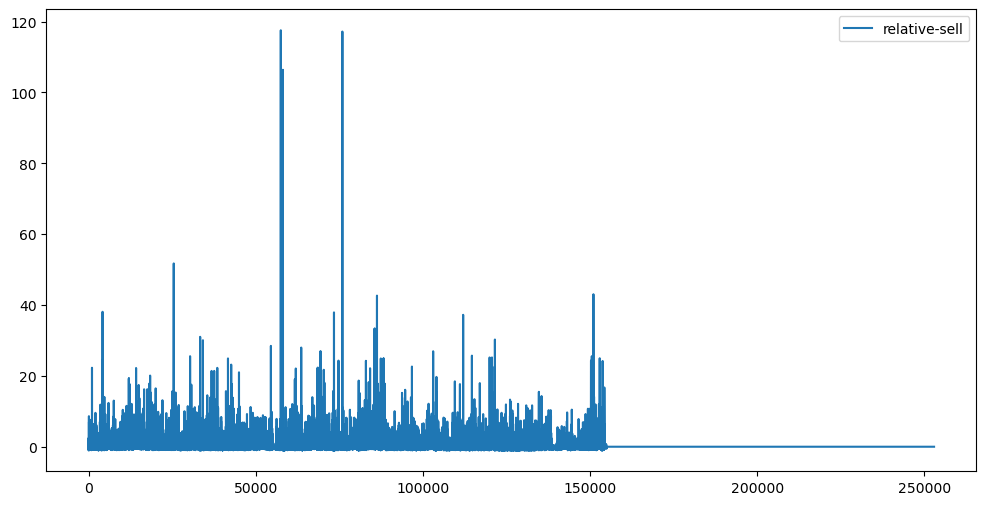

In [51]:
relative_sells.plot(figsize=(12,6))

In [52]:
sorted_rs = relative_sells.sort_values(by=['relative-sell'], ascending=False).reset_index(drop=True)
sorted_rs = sorted_rs.groupby(['relative-sell']).count().reset_index()
sorted_rs = sorted_rs.rename(columns={"address":"count"})
sorted_rs

,relative-sell,count
0,-1.000000,2
1,-1.000000,1
2,-1.000000,2
3,-1.000000,1
4,-1.000000,1
...,...,...
84683,104.296041,1
84684,106.394411,1
84685,114.684073,1
84686,117.184936,2


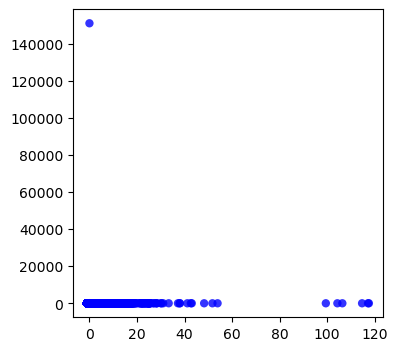

In [53]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_rs['relative-sell'] ,sorted_rs['count'] , c='blue', alpha=0.8, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

In [54]:
sorted_rs_tenth = sorted_rs
sorted_rs_tenth['tenth'] = (sorted_rs_tenth ['relative-sell']*10//1)/10
sorted_rs_tenth  = sorted_rs_tenth[['tenth','count']].groupby(['tenth']).sum().reset_index()
sorted_rs_tenth = sorted_rs_tenth .rename(columns={"address":"count"})
sorted_rs_tenth .head()

,tenth,count
0,-1.0,1998
1,-0.9,3815
2,-0.8,5970
3,-0.7,7000
4,-0.6,7550


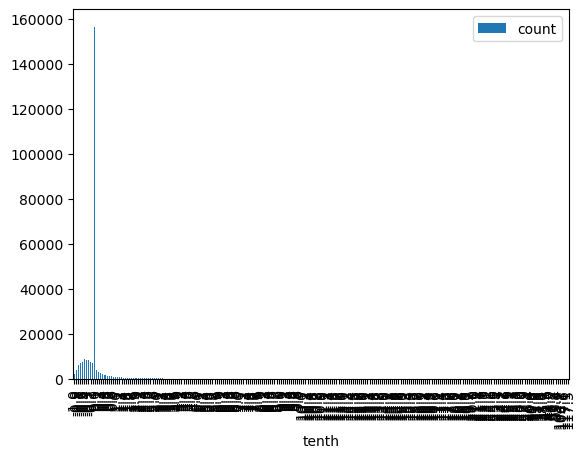

In [55]:
ax = sorted_rs_tenth.plot.bar(x='tenth',y='count')

### Relative Buy

In [56]:
relative_buys = pd.read_sql_query("SELECT name, block_timestamp as time, price, to_address as address from combined", conn)
relative_buys['time'] = pd.to_datetime(relative_buys['time']).dt.strftime('%Y-%m-%d')
relative_buys = relative_buys.merge(grouped_collection_item, how='left', on=['name','time'])
relative_buys = relative_buys[relative_buys['address'] != '0x0000000000000000000000000000000000000000']
relative_buys = relative_buys[relative_buys['price'] != 0]
relative_buys['relative-buy'] = (relative_buys['price'] - relative_buys['EMA7'])/relative_buys['EMA7']
relative_buys = relative_buys[['address','relative-buy']].groupby(['address']).mean().reset_index()
relative_buys = df_wallets.merge(relative_buys,how='left')
relative_buys = relative_buys.fillna(0)
relative_buys

,address,relative-buy
0,0x744a1ee51766d9d30229a46b62ef84a8a481470f,0.000000
1,0x5df4660295bed7abc783480c7d28d8c015cfb37a,0.000000
2,0x3d41199226f984505d7be029057c23be4a44795e,-0.089307
3,0x543154e6914d93a137b0749d2e6432a4d597df49,0.021192
4,0xb240163d43e29e2d1f5b7c00e0f6da0f2b7ca79d,-0.335949
...,...,...
252919,0x6bf8ee9de4a4876cf5b88fcd5bb343e6871bae4a,0.234429
252920,0x6ef8c88e31f36b99afd4584e25d4f69b0793187b,0.234429
252921,0xb2067abf5f1eb2e748ccbac4127b70c2ef90f202,0.234429
252922,0x4fc6c7c10410d54e20f041475fb50be535d7ec76,0.234429


##### Vis & Analysis

In [57]:
relative_buys.describe()

,relative-buy
count,252924.000000
mean,-0.181881
std,0.879998
min,-1.000000
25%,-0.538571
50%,-0.141151
75%,0.000000
max,117.549533


In [59]:
relative_buys[relative_buys['relative-buy'] == relative_buys['relative-buy'].max()]

,address,relative-buy
188330,0xb2a4f9f5082e3d58dc124d5074a38258e8577a5f,117.549533


In [142]:
sorted_rb = relative_buys.sort_values(by=['relative-buy'], ascending=False).reset_index(drop=True)
sorted_rb = sorted_rb.groupby(['relative-buy']).count().reset_index()
sorted_rb = sorted_rb.rename(columns={"address":"count"})
sorted_rb

,relative-buy,count
0,-1.000000,3
1,-1.000000,1
2,-1.000000,1
3,-1.000000,1
4,-1.000000,1
...,...,...
106590,3.496274,1
106591,3.520819,1
106592,3.599587,1
106593,4.145722,1


In [143]:
sorted_rb_tenth = sorted_rb
sorted_rb_tenth['tenth'] = (sorted_rb_tenth ['relative-buy']*10//1)/10
sorted_rb_tenth  = sorted_rb_tenth[['tenth','count']].groupby(['tenth']).sum().reset_index()
sorted_rb_tenth = sorted_rb_tenth .rename(columns={"address":"count"})
sorted_rb_tenth .head()

,tenth,count
0,-1.0,3776
1,-0.9,3966
2,-0.8,4038
3,-0.7,4368
4,-0.6,5256


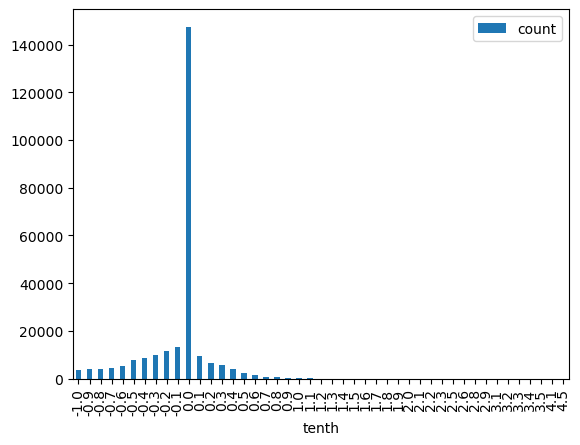

In [144]:
ax = sorted_rb_tenth.plot.bar(x='tenth',y='count')

### currency features combined

In [60]:
currency_features = total_in.merge(total_out).merge(average_in).merge(average_out).merge(std_in).merge(std_out).merge(df_profit).merge(df_profit_ratio).merge(transfer_ratio).merge(relative_buys).merge(relative_sells)
currency_features.head()

,address,total in-transaction,total out-transaction,average in-transaction,average out-transaction,std in-transaction,std out-transaction,profit-from-zero,profit-ratio,transfer-num,relative-buy,relative-sell
0,0x0000000000000000000000000000000000000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,41.0,0.0,0.0
1,0x000000000000000000000000000000000000d3a0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,15.0,0.0,0.0
2,0x000000000000000000000000000000000000dead,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,6487.0,0.0,0.0
3,0x000000000000660def84e69995117c0176ba446e,1.317993e-15,1.317993e-15,1.317993e-15,1.317993e-15,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,-0.5,4.0,0.0,0.0


In [65]:
currency_features.to_sql("currency_features", conn, if_exists='replace', index=False)

252924

##### Vis & Analysis

In [61]:
print("account number:",currency_features.shape[0])

account number: 252924


In [62]:
currency_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252924 entries, 0 to 252923
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   address                  252924 non-null  object 
 1   total in-transaction     252924 non-null  float64
 2   total out-transaction    252924 non-null  float64
 3   average in-transaction   252924 non-null  float64
 4   average out-transaction  252924 non-null  float64
 5   std in-transaction       252924 non-null  float64
 6   std out-transaction      252924 non-null  float64
 7   profit-from-zero         252924 non-null  float64
 8   profit-ratio             252924 non-null  float64
 9   transfer-num             252924 non-null  float64
 10  relative-buy             252924 non-null  float64
 11  relative-sell            252924 non-null  float64
dtypes: float64(11), object(1)
memory usage: 25.1+ MB


<AxesSubplot:>

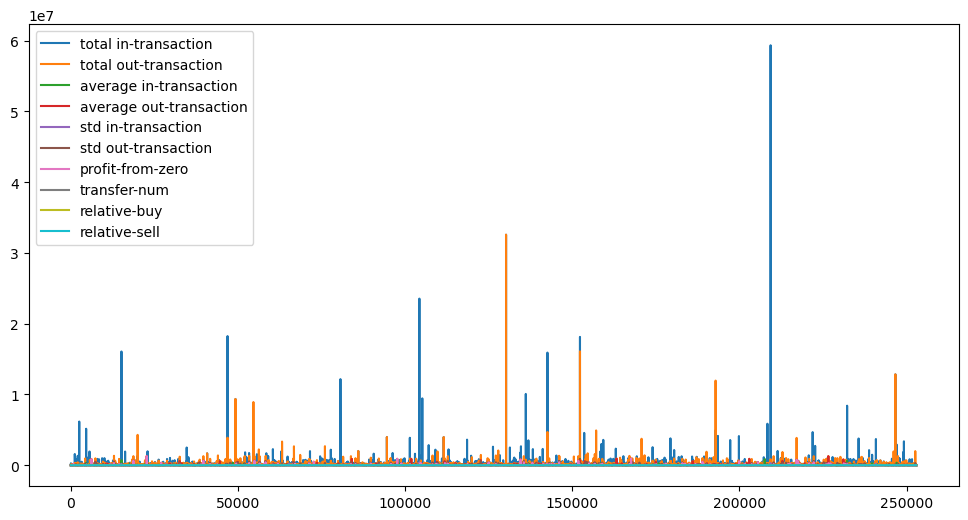

In [63]:
currency_features.drop(columns=['profit-ratio']).plot(figsize=((12,6)))

<AxesSubplot:>

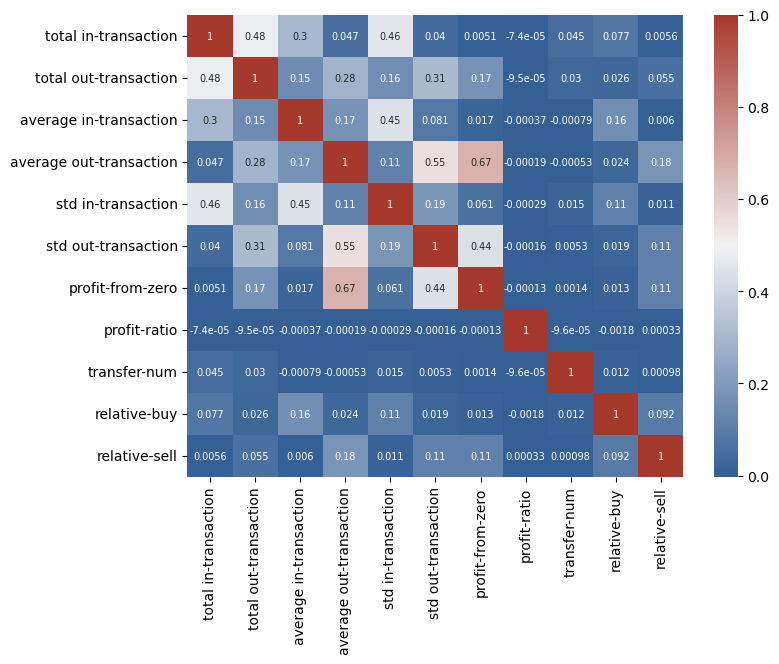

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cor = currency_features.corr()
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize = (8,6))
sns.heatmap(cor,annot=True,annot_kws={"size": 7},cmap=cmap)

In [150]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = currency_features[considered_features]
    X['intercept'] = 1
    
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = ['total in-transaction', 'total out-transaction','average in-transaction','average out-transaction','std in-transaction','std out-transaction','profit-from-zero','profit-ratio','transfer-ratio','relative-buy','relative-sell']
compute_vif(considered_features)

/home/BC-AD-1/miniconda3/envs/nftenv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,total in-transaction,1.730520
1,total out-transaction,1.537599
2,average in-transaction,1.382931
3,average out-transaction,2.355414
4,std in-transaction,1.566111
5,std out-transaction,1.585794
6,profit-from-zero,1.904508
7,profit-ratio,1.000145
8,transfer-ratio,1.040502
9,relative-buy,1.111564


In [151]:
def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()
    
    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Subset the matrix
    reduced_matrix = matrix.mask(mask)
    
    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]
    
    return to_drop

In [152]:
temp = currency_features.drop(columns=['address'])
matrix = temp.corr().abs()
mask = np.triu(np.ones_like(matrix, dtype=bool))
reduced_matrix = matrix.mask(mask)
to_drop = identify_correlated(temp, threshold=.9)
print(to_drop)

[]


## Time-based features

### average time interval between in-transactions

In [66]:
average_time_in = pd.read_sql_query("SELECT to_address as address, block_timestamp as time from combined", conn)
average_time_in = df_wallets.merge(average_time_in, how = 'left')
average_time_in['time'] = pd.to_datetime(average_time_in['time'])
average_time_in = average_time_in.groupby('address').agg({
         'time': lambda group: group.sort_values().diff().mean()})
average_time_in = average_time_in.rename(columns={'time':'interval in-transaction'})
average_time_in = average_time_in.reset_index()
average_time_in = average_time_in.fillna(datetime.timedelta(days=0))
average_time_in['interval in-transaction'] = average_time_in['interval in-transaction'].dt.days
average_time_in

,address,interval in-transaction
0,0x0000000000000000000000000000000000000001,1
1,0x000000000000000000000000000000000000d3a0,0
2,0x000000000000000000000000000000000000dead,0
3,0x000000000000660def84e69995117c0176ba446e,0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,0
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,0
252921,0xffff83075509851dca62ca604f191478ff041fd3,22
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,15


##### Vis & Analysis

In [32]:
print(average_time_in.describe())
print("account number:",average_time_in.shape[0])

       interval in-transaction
count            252924.000000
mean                  9.574947
std                  31.777120
min                   0.000000
25%                   0.000000
50%                   0.000000
75%                   2.000000
max                1270.000000
account number: 252924


<AxesSubplot:>

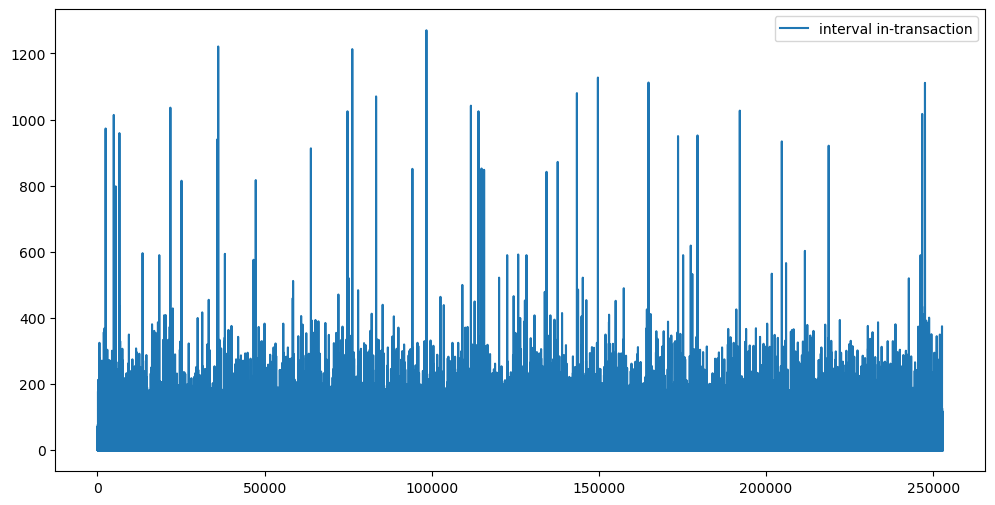

In [33]:
average_time_in.plot(figsize=((12,6)))

In [34]:
sorted_t_in = average_time_in.sort_values(by=['interval in-transaction'], ascending=False).reset_index(drop=True)
sorted_t_in = sorted_t_in.groupby(['interval in-transaction']).count().reset_index()
sorted_t_in = sorted_t_in.rename(columns={"address":"count"})
sorted_t_in

,interval in-transaction,count
0,0,182774
1,1,5892
2,2,4020
3,3,3214
4,4,2679
...,...,...
454,1112,1
455,1127,1
456,1213,1
457,1221,1


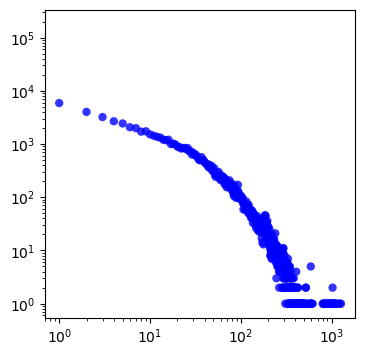

In [35]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_t_in['interval in-transaction'] ,sorted_t_in['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### average time interval between out-transactions

In [67]:
average_time_out = pd.read_sql_query("SELECT from_address as address, block_timestamp as time from combined", conn)
average_time_out = df_wallets.merge(average_time_out, how = 'left')
average_time_out['time'] = pd.to_datetime(average_time_out['time'])
average_time_out = average_time_out.groupby('address').agg({
         'time': lambda group: group.sort_values().diff().mean()})
average_time_out = average_time_out.rename(columns={'time':'interval out-transaction'})
average_time_out = average_time_out.reset_index()
average_time_out = average_time_out.fillna(datetime.timedelta(minutes=0))
average_time_out['interval out-transaction'] = average_time_out['interval out-transaction'].dt.days
average_time_out

,address,interval out-transaction
0,0x0000000000000000000000000000000000000001,0
1,0x000000000000000000000000000000000000d3a0,0
2,0x000000000000000000000000000000000000dead,0
3,0x000000000000660def84e69995117c0176ba446e,0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,0
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,0
252921,0xffff83075509851dca62ca604f191478ff041fd3,0
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,0


##### Vis & Analysis

In [37]:
print(average_time_out.describe())
print("account number:",average_time_out.shape[0])

       interval out-transaction
count             252924.000000
mean                   6.692540
std                   24.700907
min                    0.000000
25%                    0.000000
50%                    0.000000
75%                    0.000000
max                 1185.000000
account number: 252924


<AxesSubplot:>

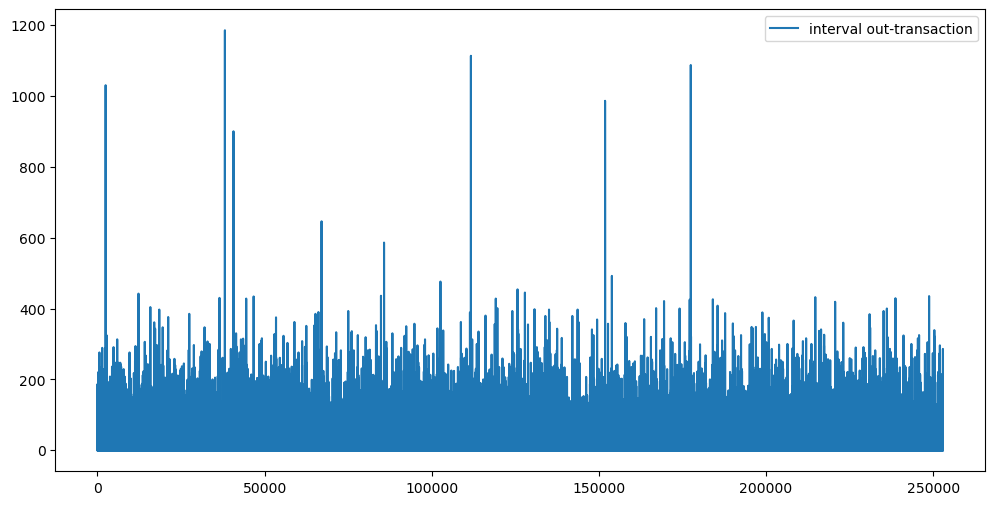

In [38]:
average_time_out.plot(figsize=((12,6)))

In [39]:
sorted_t_out = average_time_out.sort_values(by=['interval out-transaction'], ascending=False).reset_index(drop=True)
sorted_t_out = sorted_t_out.groupby(['interval out-transaction']).count().reset_index()
sorted_t_out = sorted_t_out.rename(columns={"address":"count"})
sorted_t_out

,interval out-transaction,count
0,0,201607
1,1,4010
2,2,2597
3,3,2269
4,4,1946
...,...,...
390,986,1
391,1030,1
392,1087,1
393,1113,1


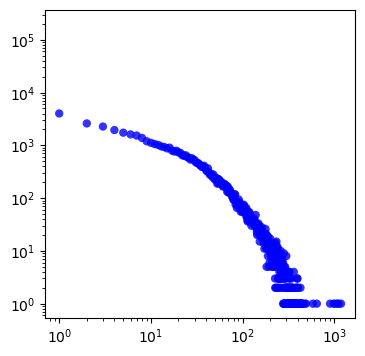

In [40]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_t_out['interval out-transaction'] ,sorted_t_out['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### difference between average time interval of in/out-transactions

In [68]:
diff_time_interval = average_time_in.merge(average_time_out)
diff_time_interval['diff time interval'] = diff_time_interval['interval in-transaction'] - diff_time_interval['interval out-transaction']
diff_time_interval = diff_time_interval.drop(columns = ["interval in-transaction","interval out-transaction"])
diff_time_interval


,address,diff time interval
0,0x0000000000000000000000000000000000000001,1
1,0x000000000000000000000000000000000000d3a0,0
2,0x000000000000000000000000000000000000dead,0
3,0x000000000000660def84e69995117c0176ba446e,0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,0
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,0
252921,0xffff83075509851dca62ca604f191478ff041fd3,22
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,15


##### Vis & Analysis

In [42]:
print(diff_time_interval.describe())
print("account number:",diff_time_interval.shape[0])

       diff time interval
count       252924.000000
mean             2.882407
std             31.177005
min          -1067.000000
25%              0.000000
50%              0.000000
75%              0.000000
max           1270.000000
account number: 252924


<AxesSubplot:>

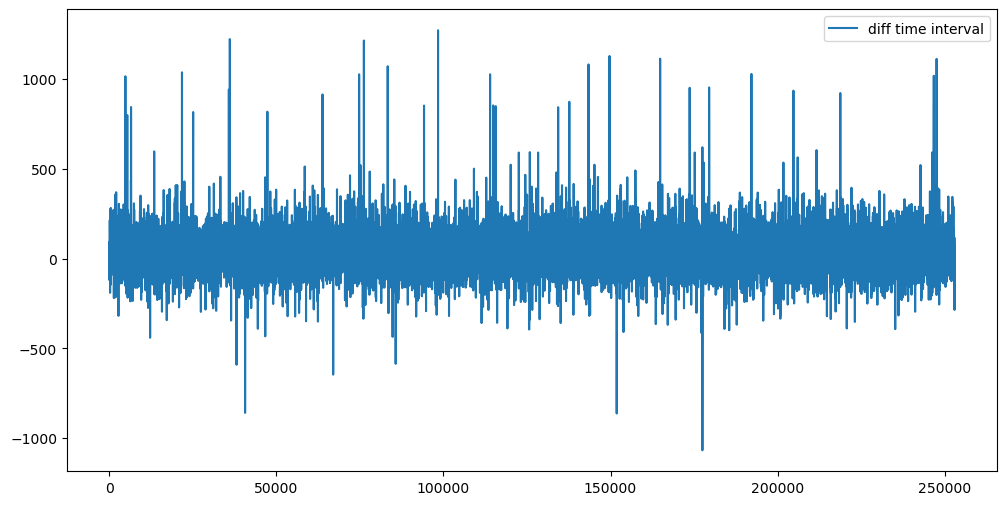

In [43]:
diff_time_interval.plot(figsize=((12,6)))

In [44]:
sorted_t_diff = diff_time_interval.sort_values(by=['diff time interval'], ascending=False).reset_index(drop=True)
sorted_t_diff = sorted_t_diff.groupby(['diff time interval']).count().reset_index()
sorted_t_diff = sorted_t_diff.rename(columns={"address":"count"})
sorted_t_diff

,diff time interval,count
0,-1067,1
1,-862,1
2,-859,1
3,-646,1
4,-591,1
...,...,...
758,1112,1
759,1127,1
760,1213,1
761,1221,1


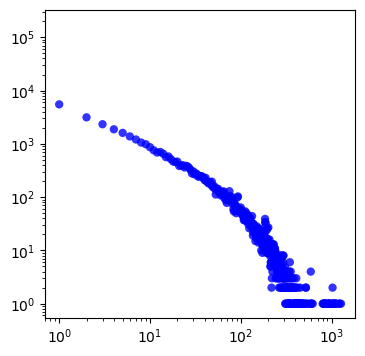

In [45]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_t_diff['diff time interval'] ,sorted_t_diff['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### Max transaction per day

In [69]:
df1 = pd.read_sql_query("SELECT block_timestamp,from_address as address from combined", conn)
df2 = pd.read_sql_query("SELECT block_timestamp,to_address as address from combined", conn)
max_trans = pd.concat([df1,df2])
max_trans = max_trans[max_trans['address'] != "0x0000000000000000000000000000000000000000"]
max_trans['time'] = pd.to_datetime(max_trans['block_timestamp'])
max_trans = max_trans.groupby(['address','time']).count().max(level=0)
max_trans = max_trans.rename(columns={'block_timestamp':'max trans'})
max_trans = max_trans.reset_index()
max_trans = max_trans.merge(df_wallets)
max_trans

/tmp/ipykernel_336227/577647239.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  max_trans = max_trans.groupby(['address','time']).count().max(level=0)


,address,max trans
0,0x0000000000000000000000000000000000000001,20
1,0x000000000000000000000000000000000000d3a0,15
2,0x000000000000000000000000000000000000dead,988
3,0x000000000000660def84e69995117c0176ba446e,2
4,0x000000000000fd461ca2d54e8f4b3e37749df921,2
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,1
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,1
252921,0xffff83075509851dca62ca604f191478ff041fd3,1
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,12


##### Vis & Analysis

In [47]:
print(max_trans.describe())
print("account number:",max_trans.shape[0])

           max trans
count  252924.000000
mean        2.073809
std        11.129827
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max      5000.000000
account number: 252924


<AxesSubplot:>

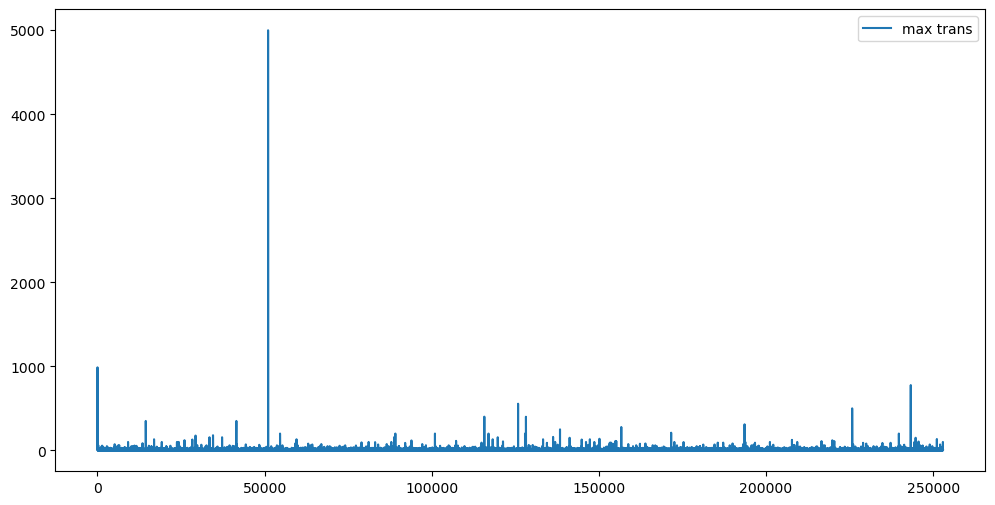

In [48]:
max_trans.plot(figsize=((12,6)))

In [49]:
sorted_max_trans = max_trans.sort_values(by=['max trans'], ascending=False).reset_index(drop=True)
sorted_max_trans = sorted_max_trans.groupby(['max trans']).count().reset_index()
sorted_max_trans= sorted_max_trans.rename(columns={"address":"count"})
sorted_max_trans

,max trans,count
0,1,167782
1,2,47256
2,3,13518
3,4,4871
4,5,8141
...,...,...
113,500,1
114,555,1
115,777,1
116,988,1


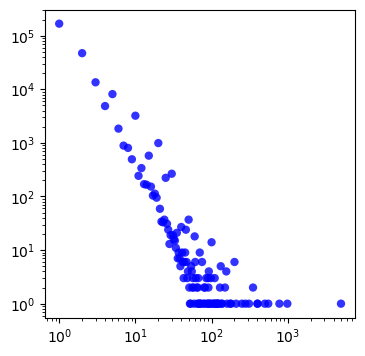

In [50]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_max_trans['max trans'] ,sorted_max_trans['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### Average transaction per day

In [70]:
df1 = pd.read_sql_query("SELECT block_timestamp,from_address as address from combined", conn)
df2 = pd.read_sql_query("SELECT block_timestamp,to_address as address from combined", conn)
average_trans = pd.concat([df1,df2])
average_trans = average_trans[average_trans['address'] != "0x0000000000000000000000000000000000000000"]
average_trans['time'] = pd.to_datetime(average_trans['block_timestamp'])
average_trans = average_trans.groupby(['address','time']).count().mean(level=0)
average_trans = average_trans.rename(columns={'block_timestamp':'avg trans'})
average_trans = average_trans.reset_index()
average_trans = average_trans.merge(df_wallets)
average_trans

/tmp/ipykernel_336227/1524710951.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  average_trans = average_trans.groupby(['address','time']).count().mean(level=0)


,address,avg trans
0,0x0000000000000000000000000000000000000001,13.666667
1,0x000000000000000000000000000000000000d3a0,15.000000
2,0x000000000000000000000000000000000000dead,6.559151
3,0x000000000000660def84e69995117c0176ba446e,2.000000
4,0x000000000000fd461ca2d54e8f4b3e37749df921,2.000000
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,1.000000
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,1.000000
252921,0xffff83075509851dca62ca604f191478ff041fd3,1.000000
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,6.666667


##### Vis & Analysis

In [52]:
print(average_trans.describe())
print("account number:",average_trans.shape[0])

           avg trans
count  252924.000000
mean        1.350332
std         1.483331
min         1.000000
25%         1.000000
50%         1.000000
75%         1.333333
max       132.000000
account number: 252924


<AxesSubplot:>

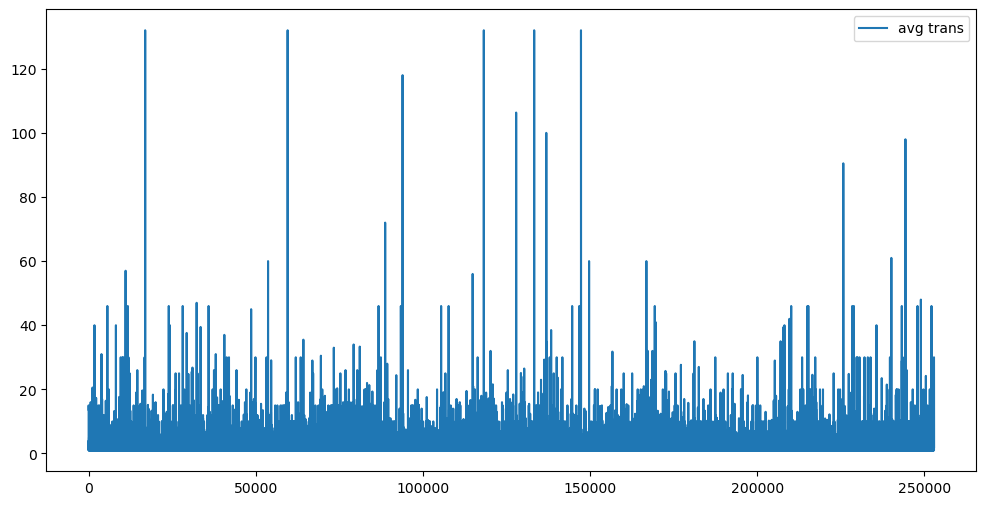

In [53]:
average_trans.plot(figsize=((12,6)))

In [54]:
sorted_avg_trans = average_trans.sort_values(by=['avg trans'], ascending=False).reset_index(drop=True)
sorted_avg_trans = sorted_avg_trans.groupby(['avg trans']).count().reset_index()
sorted_avg_trans = sorted_avg_trans.rename(columns={"address":"count"})
sorted_avg_trans

,avg trans,count
0,1.000000,167782
1,1.006135,1
2,1.007752,1
3,1.007874,1
4,1.010204,1
...,...,...
2360,98.000000,1
2361,100.000000,1
2362,106.333333,1
2363,118.000000,1


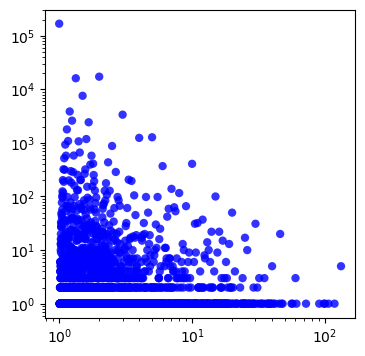

In [55]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_avg_trans['avg trans'] ,sorted_avg_trans['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### Std Transaction per Day

In [71]:
df1 = pd.read_sql_query("SELECT block_timestamp,from_address as address from combined", conn)
df2 = pd.read_sql_query("SELECT block_timestamp,to_address as address from combined", conn)
std_trans = pd.concat([df1,df2])
std_trans = std_trans[std_trans['address'] != "0x0000000000000000000000000000000000000000"]
std_trans['time'] = pd.to_datetime(std_trans['block_timestamp'])
std_trans = std_trans.groupby(['address','time']).count().std(level=0)
std_trans = std_trans.rename(columns={'block_timestamp':'std trans'})
std_trans = std_trans.reset_index()
std_trans = std_trans.fillna(0)
std_trans = std_trans.merge(df_wallets)
std_trans

/tmp/ipykernel_336227/440615778.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.var(level=1) should use df.groupby(level=1).var().
  std_trans = std_trans.groupby(['address','time']).count().std(level=0)


,address,std trans
0,0x0000000000000000000000000000000000000001,10.969655
1,0x000000000000000000000000000000000000d3a0,0.000000
2,0x000000000000000000000000000000000000dead,33.410946
3,0x000000000000660def84e69995117c0176ba446e,0.000000
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.000000
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,0.000000
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,0.000000
252921,0xffff83075509851dca62ca604f191478ff041fd3,0.000000
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,4.725816


##### Vis & Analysis

In [57]:
print(std_trans.describe())
print("account number:",std_trans.shape[0])

           std trans
count  252924.000000
mean        0.321647
std         1.238748
min         0.000000
25%         0.000000
50%         0.000000
75%         0.288675
max       200.829032
account number: 252924


<AxesSubplot:>

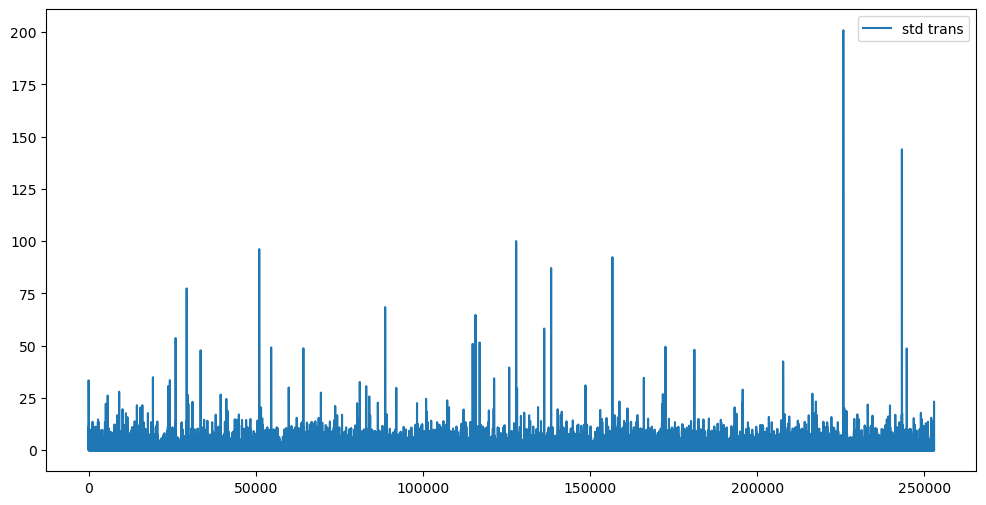

In [58]:
std_trans.plot(figsize=((12,6)))

In [59]:
sorted_std_trans = std_trans.sort_values(by=['std trans'], ascending=False).reset_index(drop=True)
sorted_std_trans = sorted_std_trans.groupby(['std trans']).count().reset_index()
sorted_std_trans = sorted_std_trans.rename(columns={"address":"count"})
sorted_std_trans

,std trans,count
0,0.000000,187959
1,0.078326,1
2,0.088045,1
3,0.088736,1
4,0.101015,1
...,...,...
8541,92.333333,1
8542,96.180767,1
8543,100.011666,1
8544,143.906801,1


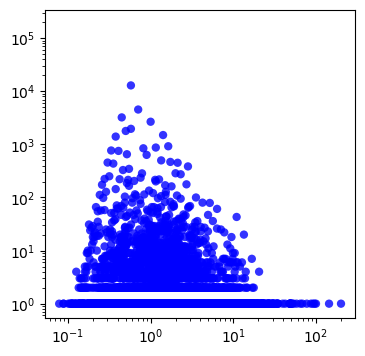

In [60]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_std_trans['std trans'] ,sorted_std_trans['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### Since Minted Average

In [72]:
df1 = pd.read_sql_query("SELECT block_timestamp,from_address,to_address,token_id,name from combined", conn)
df2 = pd.read_sql_query("SELECT block_timestamp,from_address,to_address,token_id,name from combined", conn)
# df1 = df1[df1['from_address'] != "0x0000000000000000000000000000000000000000"]
df1 = df1.drop(columns=['from_address'])
df1 = df1.rename(columns={"to_address":"address"})
# df2 = df2[df2['from_address'] != "0x0000000000000000000000000000000000000000"]
df2 = df2.drop(columns=['to_address'])
df2 = df2.rename(columns={"from_address":"address"})
average_minted = pd.concat([df1,df2])
# average_minted = average_minted[average_minted['address'] != "0x0000000000000000000000000000000000000000"]
average_minted['time'] = pd.to_datetime(average_minted['block_timestamp']).dt.strftime('%d-%b-%y')
average_minted['time'] = pd.to_datetime(average_minted['time'])
average_minted.head()


,block_timestamp,address,token_id,name,time
0,2022-10-03T18:30:59.000Z,0x95933de7546f9dfad542860355cfe2fae1e5e843,210030130,CryptoSpells,2022-10-03
1,2022-10-02T14:28:11.000Z,0x95933de7546f9dfad542860355cfe2fae1e5e843,210020208,CryptoSpells,2022-10-02
2,2022-09-12T16:10:00.000Z,0x95933de7546f9dfad542860355cfe2fae1e5e843,210020209,CryptoSpells,2022-09-12
3,2022-09-12T13:35:34.000Z,0x95933de7546f9dfad542860355cfe2fae1e5e843,210020210,CryptoSpells,2022-09-12
4,2022-09-12T04:13:22.000Z,0xbcdc510d5f4976559a49f38a7db81c4fabb0030c,210040100,CryptoSpells,2022-09-12


In [73]:
minted_date = pd.read_sql_query("SELECT * from collection_minted", conn)
minted_date['date'] = pd.to_datetime(minted_date['date'])
minted_date = minted_date[['name','token_id','date']].groupby(['name','token_id']).agg(Minimum_Date=('date', np.min))
minted_date = minted_date.reset_index()
minted_date = minted_date.rename(columns={'Minimum_Date':'date'})
minted_date

,name,token_id,date
0,8th Wonders by 8th Project,0,2021-12-18 18:40:23
1,8th Wonders by 8th Project,1,2021-12-18 20:07:26
2,8th Wonders by 8th Project,10,2021-12-18 20:07:58
3,8th Wonders by 8th Project,100,2021-12-18 21:27:18
4,8th Wonders by 8th Project,1000,2021-12-29 17:19:58
...,...,...,...
523256,vSamurai Genesis,995,2022-04-22 23:42:55
523257,vSamurai Genesis,996,2022-04-22 23:42:55
523258,vSamurai Genesis,997,2022-04-22 23:42:55
523259,vSamurai Genesis,998,2022-04-22 23:42:55


In [74]:
df_minted = average_minted.merge(minted_date, on=['name','token_id'], how='left')
df_minted = df_minted.rename(columns={'date':'minted_date'})
df_minted['minted_date'] = pd.to_datetime(df_minted['minted_date']).dt.strftime('%d-%b-%y')
df_minted['minted_date'] = pd.to_datetime(df_minted['minted_date'])
df_minted['since_minted'] = df_minted['time'] - df_minted['minted_date']
# df_minted['since_minted_min'] = df_minted['time'] - df_minted['Minimum_Date']
# df_minted['since_minted_max'] = df_minted['time'] - df_minted['Maximum_Date']
df_minted.head()

,block_timestamp,address,token_id,name,time,minted_date,since_minted
0,2022-10-03T18:30:59.000Z,0x95933de7546f9dfad542860355cfe2fae1e5e843,210030130,CryptoSpells,2022-10-03,2020-01-07,1000 days
1,2022-10-02T14:28:11.000Z,0x95933de7546f9dfad542860355cfe2fae1e5e843,210020208,CryptoSpells,2022-10-02,2020-01-07,999 days
2,2022-09-12T16:10:00.000Z,0x95933de7546f9dfad542860355cfe2fae1e5e843,210020209,CryptoSpells,2022-09-12,2020-01-07,979 days
3,2022-09-12T13:35:34.000Z,0x95933de7546f9dfad542860355cfe2fae1e5e843,210020210,CryptoSpells,2022-09-12,2020-01-07,979 days
4,2022-09-12T04:13:22.000Z,0xbcdc510d5f4976559a49f38a7db81c4fabb0030c,210040100,CryptoSpells,2022-09-12,2020-01-07,979 days


In [75]:
avg_minted = df_minted[['address','since_minted']].groupby(['address']).mean()
avg_minted = avg_minted.rename(columns={'since_minted':'avg minted days'})
avg_minted = avg_minted.reset_index()
avg_minted['avg minted days'] = avg_minted['avg minted days'].dt.components.days
mean_val = int(avg_minted['avg minted days'].mean())
avg_minted['avg minted days'] = avg_minted['avg minted days'].fillna(mean_val)
avg_minted = avg_minted.merge(df_wallets)
avg_minted

,address,avg minted days
0,0x0000000000000000000000000000000000000001,3.0
1,0x000000000000000000000000000000000000d3a0,198.0
2,0x000000000000000000000000000000000000dead,16.0
3,0x000000000000660def84e69995117c0176ba446e,16.0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,1.0
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,3.0
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,0.0
252921,0xffff83075509851dca62ca604f191478ff041fd3,208.0
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,232.0


##### Vis & Analysis

In [65]:
print(avg_minted.describe())
print("account number:",avg_minted.shape[0])

       avg minted days
count    252924.000000
mean         36.906260
std          73.336318
min           0.000000
25%           0.000000
50%           5.000000
75%          38.000000
max        1280.000000
account number: 252924


<AxesSubplot:>

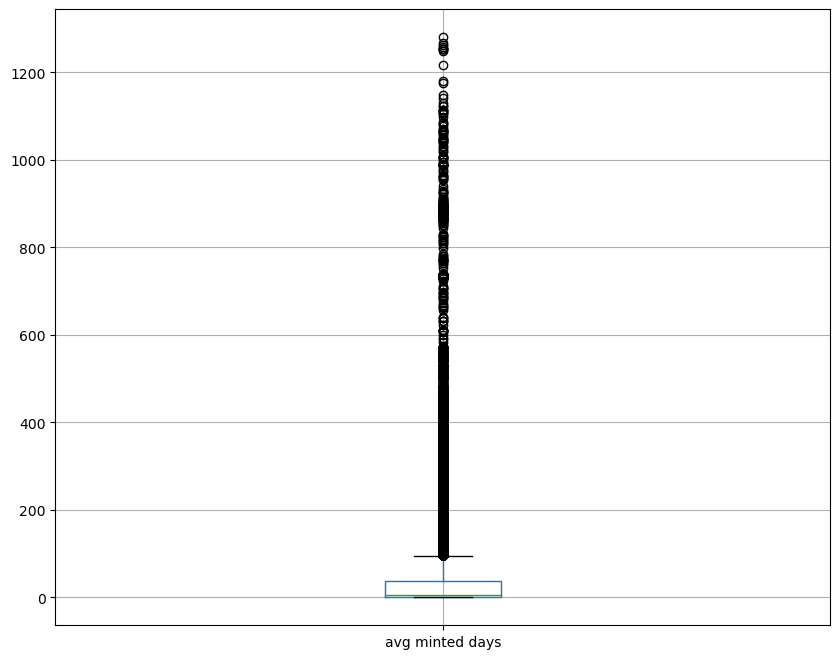

In [66]:
# avg_minted.plot(figsize=((12,6)))
avg_minted.boxplot(figsize=(10,8))  

In [67]:
df_minted[df_minted['since_minted'] < datetime.timedelta(minutes=0)]

,block_timestamp,address,token_id,name,time,minted_date,since_minted


In [68]:
sorted_mint = avg_minted.sort_values(by=['avg minted days'], ascending=False).reset_index(drop=True)
sorted_mint = sorted_mint.groupby(['avg minted days']).count().reset_index()
sorted_mint = sorted_mint.rename(columns={"address":"count"})
sorted_mint

,avg minted days,count
0,0.0,82320
1,1.0,16505
2,2.0,9196
3,3.0,7407
4,4.0,6716
...,...,...
721,1254.0,4
722,1257.0,1
723,1262.0,1
724,1266.0,1


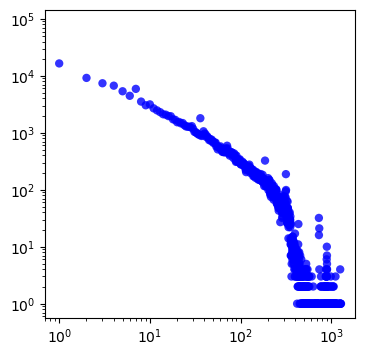

In [69]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_mint['avg minted days'] ,sorted_mint['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### Market-Trend-Buy

In [92]:
gas_eth = pd.read_csv('GAS-ETH.csv')
gas_eth = gas_eth.drop(columns=['Open','High','Low','Close','Volume'])
gas_eth = gas_eth.rename(columns={"Adj Close":"gas-eth"})
gas_eth

,Date,gas-eth
0,2017-11-11,0.063859
1,2017-11-12,0.061557
2,2017-11-13,0.062337
3,2017-11-14,0.059969
4,2017-11-15,0.066210
...,...,...
1793,2022-10-09,0.001734
1794,2022-10-10,0.001737
1795,2022-10-11,0.001700
1796,2022-10-12,0.001684


#### gas-eth MACD

In [93]:
# 26-day EMA
k = gas_eth['gas-eth'].ewm(span=12, adjust=False, min_periods=12).mean()

# 12-day EMA
d =gas_eth['gas-eth'].ewm(span=26, adjust=False, min_periods=26).mean()

macd = k - d

# 9-day EMA (of MACD) - signal line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

# Convergence Divergence value - histogram
macd_h = macd - macd_s

gas_eth['macd_h'] = macd_h
gas_eth['macd_h'] = (gas_eth['macd_h']-gas_eth['macd_h'].mean())/gas_eth['macd_h'].std()
# gas_eth['macd_h_normalized'] = gas_eth['macd_h']/gas_eth['macd_h'].std()

gas_eth

,Date,gas-eth,macd_h
0,2017-11-11,0.063859,NaN
1,2017-11-12,0.061557,NaN
2,2017-11-13,0.062337,NaN
3,2017-11-14,0.059969,NaN
4,2017-11-15,0.066210,NaN
...,...,...,...
1793,2022-10-09,0.001734,-0.059492
1794,2022-10-10,0.001737,-0.056372
1795,2022-10-11,0.001700,-0.062623
1796,2022-10-12,0.001684,-0.069626


In [94]:
gas_eth = gas_eth.drop(columns=['gas-eth'])
gas_eth

,Date,macd_h
0,2017-11-11,NaN
1,2017-11-12,NaN
2,2017-11-13,NaN
3,2017-11-14,NaN
4,2017-11-15,NaN
...,...,...
1793,2022-10-09,-0.059492
1794,2022-10-10,-0.056372
1795,2022-10-11,-0.062623
1796,2022-10-12,-0.069626


<AxesSubplot:>

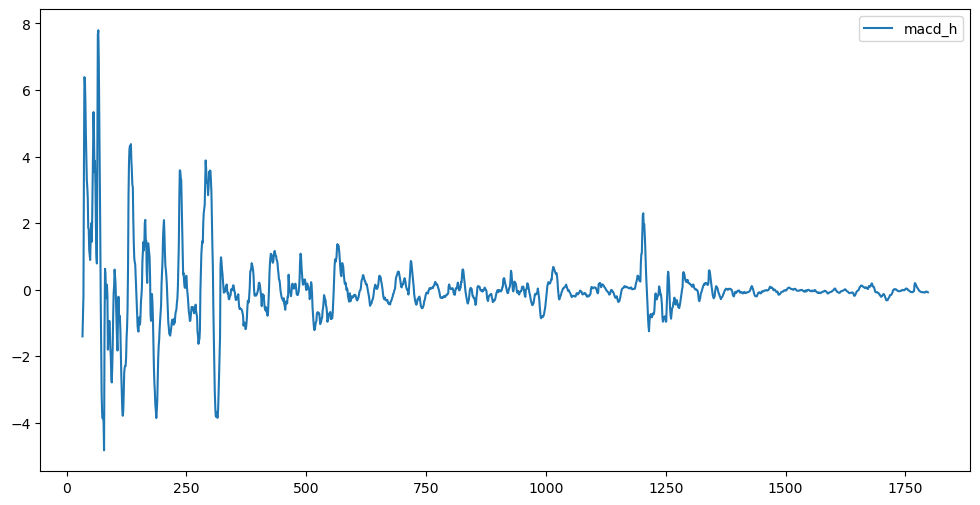

In [97]:
gas_eth.plot(figsize=(12,6))

In [95]:
buy_trend = pd.read_sql_query("SELECT to_address as address, block_timestamp as Date from combined", conn)
buy_trend['Date'] = pd.to_datetime(buy_trend['Date']).dt.strftime('%Y-%m-%d')
buy_trend = buy_trend.merge(gas_eth,how='left')
buy_trend = buy_trend.drop(columns=['Date'])
# buy_trend['macd_h'] = buy_trend['macd_h']/buy_trend['macd_h'].std()
buy_trend = buy_trend.groupby(['address']).sum().reset_index().rename(columns={"macd_h":"market-trend-buy"})
buy_trend = buy_trend.merge(df_wallets)
buy_trend

,address,market-trend-buy
0,0x0000000000000000000000000000000000000001,-8.157984
1,0x000000000000000000000000000000000000d3a0,-2.000733
2,0x000000000000000000000000000000000000dead,-1192.681947
3,0x000000000000660def84e69995117c0176ba446e,-0.015537
4,0x000000000000fd461ca2d54e8f4b3e37749df921,-0.482716
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,0.405190
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,-0.053676
252921,0xffff83075509851dca62ca604f191478ff041fd3,-0.051035
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,-1.262766


##### Vis & Analysis

In [96]:
buy_trend.describe()

,market-trend-buy
count,252924.000000
mean,-0.248323
std,10.610887
min,-4221.461050
25%,-0.212305
50%,-0.070657
75%,-0.009552
max,500.505294


<AxesSubplot:>

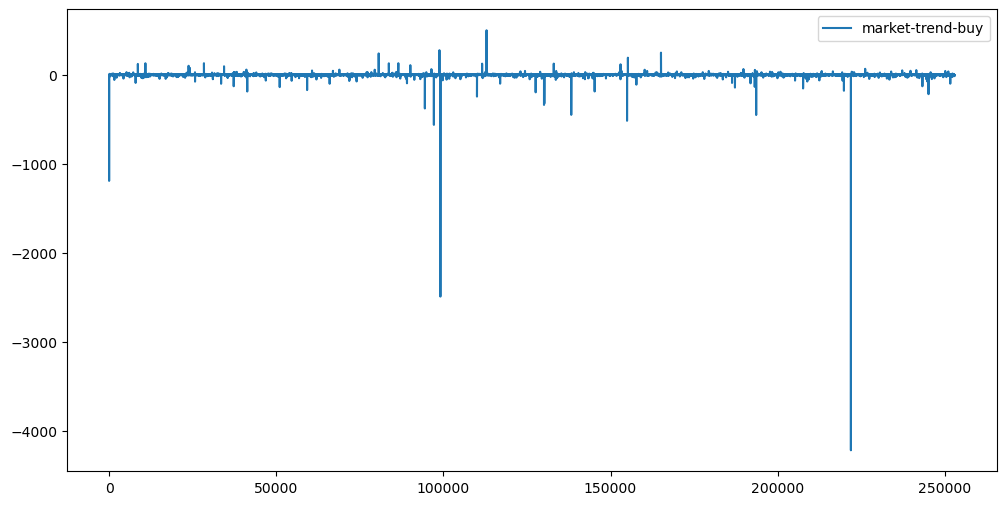

In [101]:
buy_trend.plot(figsize=(12,6))

In [77]:
sorted_market_buy = buy_trend.sort_values(by=['market-trend-buy'], ascending=False).reset_index(drop=True)
sorted_market_buy = sorted_market_buy.groupby(['market-trend-buy']).count().reset_index()
sorted_market_buy = sorted_market_buy.rename(columns={"address":"count"})
sorted_market_buy

,market-trend-buy,count
0,-1.108633,1
1,-0.640614,1
2,-0.255280,1
3,-0.122107,1
4,-0.101701,1
...,...,...
70568,0.101777,1
70569,0.102967,1
70570,0.103814,1
70571,0.115515,1


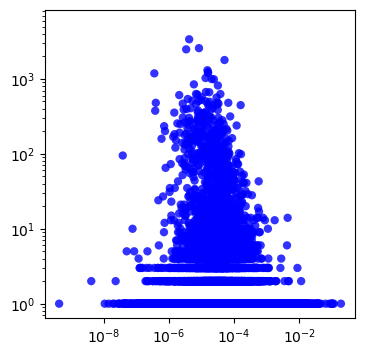

In [78]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(sorted_market_buy['market-trend-buy'] ,sorted_market_buy['count'] , c='blue', alpha=0.8, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

### Market-Trend-Sell

In [98]:
sell_trend = pd.read_sql_query("SELECT from_address as address, block_timestamp as Date from combined", conn)
sell_trend['Date'] = pd.to_datetime(sell_trend['Date']).dt.strftime('%Y-%m-%d')
sell_trend = sell_trend.merge(gas_eth,how='left')
sell_trend = sell_trend.drop(columns=['Date'])
sell_trend = sell_trend.groupby(['address']).sum().reset_index().rename(columns={"macd_h":"market-trend-sell"})
sell_trend = sell_trend.merge(df_wallets)
sell_trend = sell_trend.merge(df_wallets,how='right')
sell_trend = sell_trend.fillna(0)
sell_trend

,address,market-trend-sell
0,0x744a1ee51766d9d30229a46b62ef84a8a481470f,-0.076301
1,0x5df4660295bed7abc783480c7d28d8c015cfb37a,-2.883495
2,0x3d41199226f984505d7be029057c23be4a44795e,-0.046694
3,0x543154e6914d93a137b0749d2e6432a4d597df49,0.817384
4,0xb240163d43e29e2d1f5b7c00e0f6da0f2b7ca79d,0.003858
...,...,...
252919,0x6bf8ee9de4a4876cf5b88fcd5bb343e6871bae4a,0.000000
252920,0x6ef8c88e31f36b99afd4584e25d4f69b0793187b,0.000000
252921,0xb2067abf5f1eb2e748ccbac4127b70c2ef90f202,0.000000
252922,0x4fc6c7c10410d54e20f041475fb50be535d7ec76,0.000000


##### Vis & Analysis

In [99]:
sell_trend.describe()

,market-trend-sell
count,252924.000000
mean,-0.118723
std,2.097009
min,-575.001726
25%,-0.098281
50%,0.000000
75%,0.000000
max,87.197232


<AxesSubplot:>

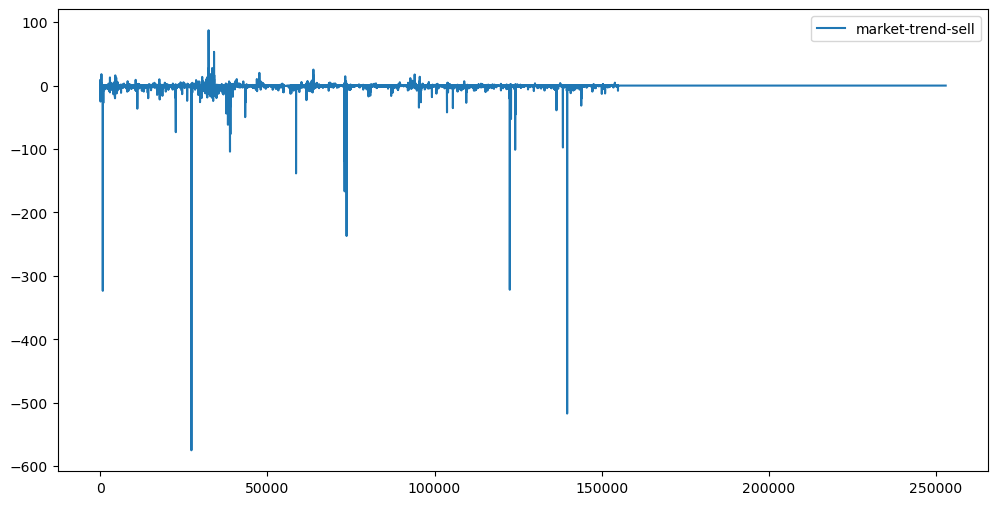

In [100]:
sell_trend.plot(figsize=(12,6))

### Market-Volatility-Buy

In [47]:
gas_eth = pd.read_csv('GAS-ETH.csv')
gas_eth = gas_eth.drop(columns=['Open','Close','Volume'])
gas_eth = gas_eth.rename(columns={"Adj Close":"Close"})
gas_eth

,Date,High,Low,Close
0,2017-11-11,0.073923,0.064665,0.063859
1,2017-11-12,0.066451,0.057534,0.061557
2,2017-11-13,0.066649,0.057861,0.062337
3,2017-11-14,0.062536,0.059755,0.059969
4,2017-11-15,0.066204,0.056896,0.066210
...,...,...,...,...
1793,2022-10-09,0.001781,0.001738,0.001734
1794,2022-10-10,0.001726,0.001730,0.001737
1795,2022-10-11,0.001749,0.001679,0.001700
1796,2022-10-12,0.001686,0.001669,0.001684


In [48]:
# gas_atr 
high_low = gas_eth['High'] - gas_eth['Low']
high_close = np.abs(gas_eth['High'] - gas_eth['Close'].shift())
low_close = np.abs(gas_eth['Low'] - gas_eth['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
gas_atr = true_range.rolling(14).sum()/14
gas_eth['ATR'] = gas_atr
# Remove NaN values in high, low, and close rows by interpolation.
gas_eth = gas_eth.interpolate()
gas_eth[gas_eth['ATR'].isna()].head(20)
gas_eth['ATR'] = (gas_eth['ATR']-gas_eth['ATR'].mean())/gas_eth['ATR'].std()

<AxesSubplot:>

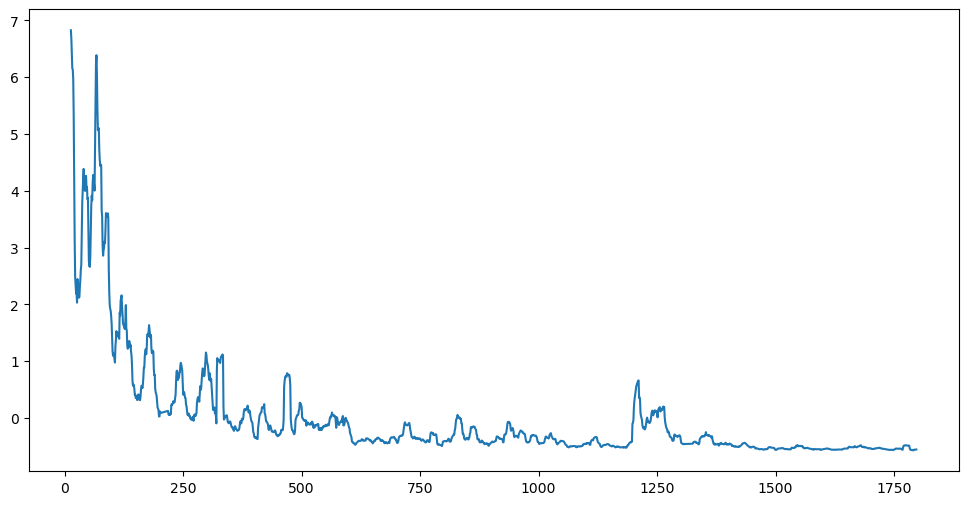

In [49]:
gas_eth['ATR'].plot(figsize=(12,6))

In [50]:
buy_vol = pd.read_sql_query("SELECT to_address as address, block_timestamp as Date from combined", conn)
buy_vol['Date'] = pd.to_datetime(buy_vol['Date']).dt.strftime('%Y-%m-%d')
buy_vol = buy_vol.merge(gas_eth,how='left')
buy_vol = buy_vol.drop(columns=['Date','High','Low','Close'])
buy_vol = buy_vol.groupby(['address']).mean().reset_index().rename(columns={"ATR":"buy-ATR"})
buy_vol = buy_vol.merge(df_wallets)
buy_vol

,address,buy-ATR
0,0x0000000000000000000000000000000000000001,-0.469381
1,0x000000000000000000000000000000000000d3a0,-0.547502
2,0x000000000000000000000000000000000000dead,-0.534330
3,0x000000000000660def84e69995117c0176ba446e,-0.487529
4,0x000000000000fd461ca2d54e8f4b3e37749df921,-0.540923
...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,-0.452299
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,-0.540733
252921,0xffff83075509851dca62ca604f191478ff041fd3,-0.560493
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,-0.494230


##### Vis & Analysis

In [51]:
buy_vol.describe()

,buy-ATR
count,252924.000000
mean,-0.513722
std,0.070645
min,-0.570051
25%,-0.549504
50%,-0.532104
75%,-0.505645
max,0.659866


<AxesSubplot:>

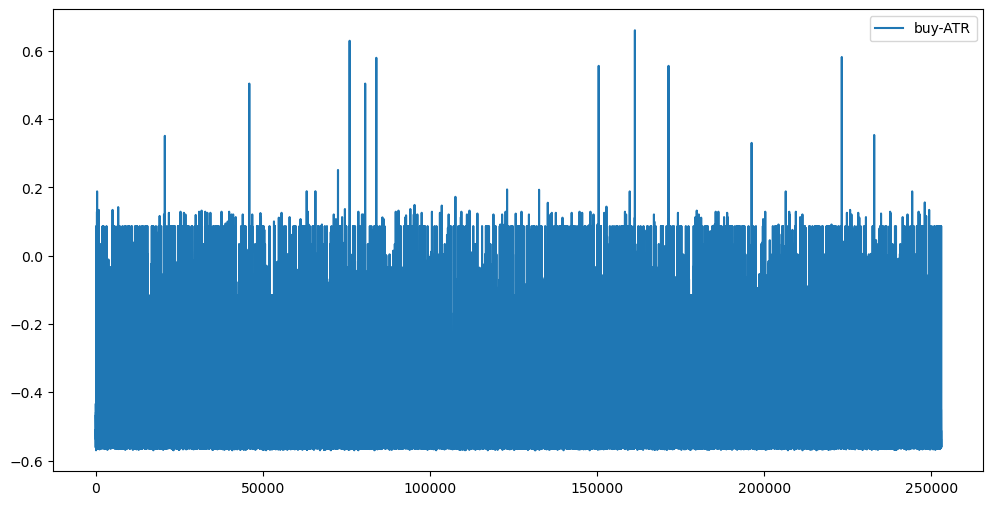

In [109]:
buy_vol.plot(figsize=(12,6))

### Market-Volatility-Sell

In [110]:
sell_vol = pd.read_sql_query("SELECT from_address as address, block_timestamp as Date from combined", conn)
sell_vol['Date'] = pd.to_datetime(sell_vol['Date']).dt.strftime('%Y-%m-%d')
sell_vol = sell_vol.merge(gas_eth,how='left')
sell_vol = sell_vol.drop(columns=['Date','High','Low','Close'])
# buy_trend['macd_h'] = buy_trend['macd_h']/buy_trend['macd_h'].std()
sell_vol = sell_vol.groupby(['address']).mean().reset_index().rename(columns={"ATR":"sell-ATR"})
sell_vol = sell_vol.merge(df_wallets,how='right')
sell_vol = sell_vol.fillna(0)
sell_vol

,address,sell-ATR
0,0x744a1ee51766d9d30229a46b62ef84a8a481470f,-0.566524
1,0x5df4660295bed7abc783480c7d28d8c015cfb37a,-0.439224
2,0x3d41199226f984505d7be029057c23be4a44795e,-0.542973
3,0x543154e6914d93a137b0749d2e6432a4d597df49,-0.557766
4,0xb240163d43e29e2d1f5b7c00e0f6da0f2b7ca79d,-0.562757
...,...,...
252919,0x6bf8ee9de4a4876cf5b88fcd5bb343e6871bae4a,0.000000
252920,0x6ef8c88e31f36b99afd4584e25d4f69b0793187b,0.000000
252921,0xb2067abf5f1eb2e748ccbac4127b70c2ef90f202,0.000000
252922,0x4fc6c7c10410d54e20f041475fb50be535d7ec76,0.000000


##### Vis & Analysis

In [111]:
sell_vol.describe()

,sell-ATR
count,252924.000000
mean,-0.319765
std,0.257595
min,-0.570051
25%,-0.541209
50%,-0.496969
75%,0.000000
max,0.659866


<AxesSubplot:>

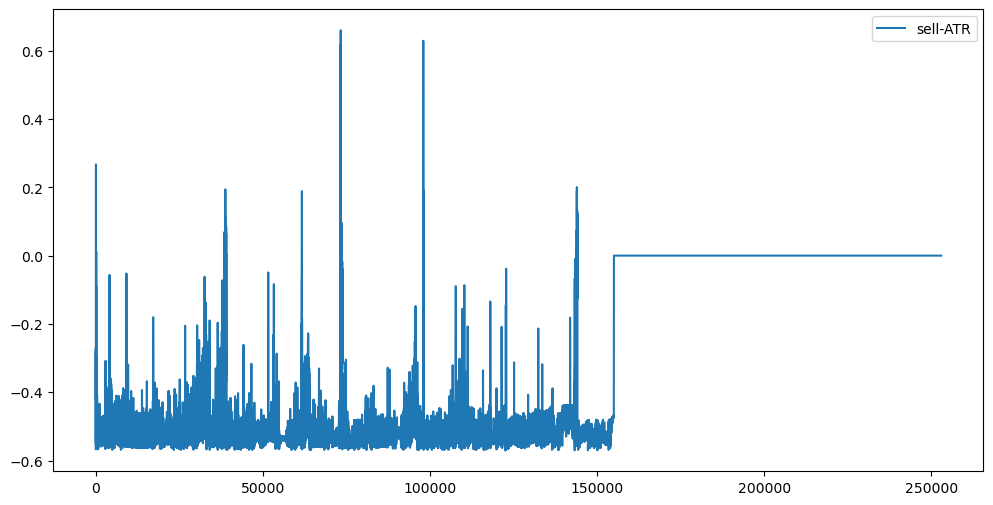

In [112]:
sell_vol.plot(figsize=(12,6))

### time-based features combined

In [113]:
time_features = average_time_in.merge(average_time_out).merge(diff_time_interval).merge(max_trans).merge(average_trans).merge(std_trans).merge(avg_minted).merge(buy_trend).merge(sell_trend).merge(buy_vol).merge(sell_vol)
time_features.head()

,address,interval in-transaction,interval out-transaction,diff time interval,max trans,avg trans,std trans,avg minted days,market-trend-buy,market-trend-sell,buy-ATR,sell-ATR
0,0x0000000000000000000000000000000000000001,1,0,1,20,13.666667,10.969655,3.0,-8.157984,0.000000,-0.469381,0.000000
1,0x000000000000000000000000000000000000d3a0,0,0,0,15,15.000000,0.000000,198.0,-2.000733,0.000000,-0.547502,0.000000
2,0x000000000000000000000000000000000000dead,0,0,0,988,6.559151,33.410946,16.0,-1192.681947,0.000000,-0.534330,0.000000
3,0x000000000000660def84e69995117c0176ba446e,0,0,0,2,2.000000,0.000000,16.0,-0.015537,-0.015537,-0.487529,-0.487529
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0,0,0,2,2.000000,0.000000,1.0,-0.482716,-0.482716,-0.540923,-0.540923


In [117]:
time_features.to_sql("time_features", conn, if_exists='replace', index=False)

252924

##### Vis & Analysis

In [114]:
print("account number:",time_features.shape[0])

account number: 252924


<AxesSubplot:>

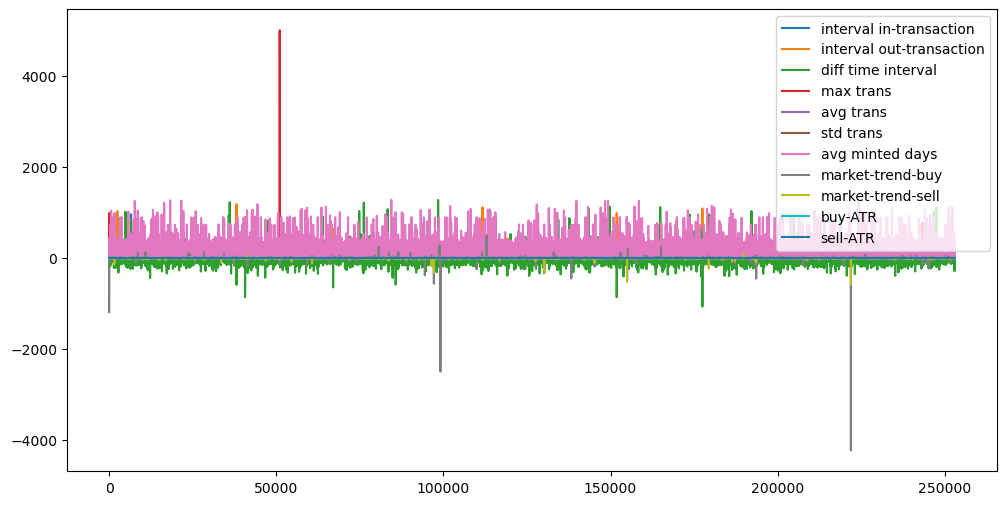

In [115]:
time_features.plot(figsize=((12,6)))

<AxesSubplot:>

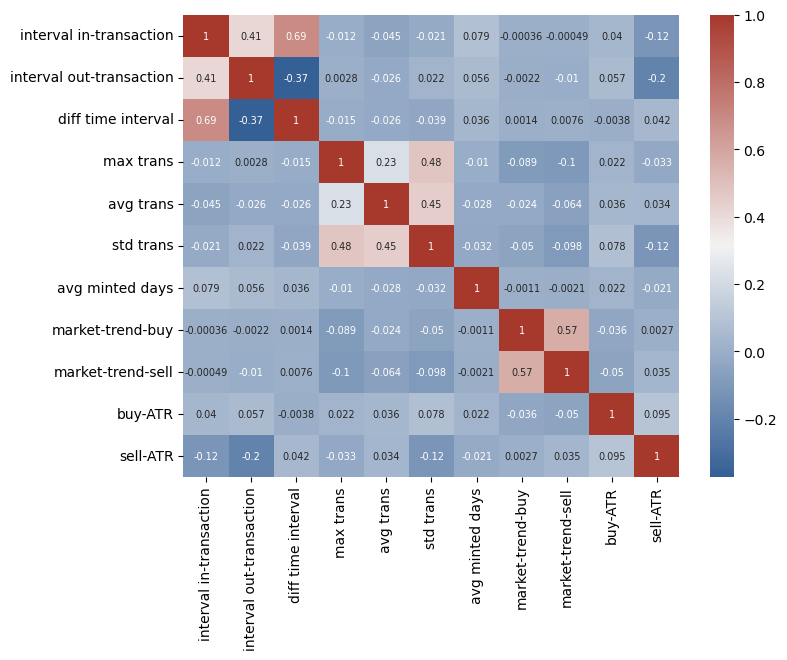

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cor = time_features.corr()
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize = (8,6))
sns.heatmap(cor,annot=True,annot_kws={"size": 7},cmap=cmap)

### Combined Features

In [43]:
combined_features = network_features.merge(currency_features).merge(time_features)


In [7]:
network_features = pd.read_sql_query("SELECT * from network_features", conn)
network_features

,address,in-degree,out-degree,unique-in ratio,unique-out ratio
0,0x0000000000000000000000000000000000000001,41,0,20.500000,0.0
1,0x000000000000000000000000000000000000d3a0,15,0,15.000000,0.0
2,0x000000000000000000000000000000000000dead,6487,0,2.644517,0.0
3,0x000000000000660def84e69995117c0176ba446e,1,1,1.000000,1.0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,2,2,1.000000,2.0
...,...,...,...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,4,0,1.000000,0.0
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,3,0,3.000000,0.0
252921,0xffff83075509851dca62ca604f191478ff041fd3,2,1,1.000000,1.0
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,20,0,10.000000,0.0


In [8]:
currency_features = pd.read_sql_query("SELECT * from currency_features", conn)
currency_features

,address,total in-transaction,total out-transaction,average in-transaction,average out-transaction,std in-transaction,std out-transaction,profit-from-zero,profit-ratio,transfer-num,relative-buy,relative-sell
0,0x0000000000000000000000000000000000000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,41.0,0.000000,0.0
1,0x000000000000000000000000000000000000d3a0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,15.0,0.000000,0.0
2,0x000000000000000000000000000000000000dead,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,6487.0,0.000000,0.0
3,0x000000000000660def84e69995117c0176ba446e,1.317993e-15,1.317993e-15,1.317993e-15,1.317993e-15,0.000000,0.0,0.0,-1.0,0.0,-1.000000,-1.0
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,-0.5,4.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,7.587058e+02,0.000000e+00,1.896764e+02,0.000000e+00,23.583934,0.0,0.0,0.0,0.0,-0.587466,0.0
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,6.977191e+02,0.000000e+00,2.325730e+02,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,-0.078820,0.0
252921,0xffff83075509851dca62ca604f191478ff041fd3,1.083324e+04,0.000000e+00,5.416622e+03,0.000000e+00,5416.621955,0.0,0.0,-1.0,2.0,-0.391591,0.0
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,20.0,0.000000,0.0


In [9]:
time_features = pd.read_sql_query("SELECT * from time_features", conn)
time_features

,address,interval in-transaction,interval out-transaction,diff time interval,max trans,avg trans,std trans,avg minted days,market-trend-buy,market-trend-sell,buy-ATR,sell-ATR
0,0x0000000000000000000000000000000000000001,1,0,1,20,13.666667,10.969655,3.0,-8.157984,0.000000,-0.469381,0.000000
1,0x000000000000000000000000000000000000d3a0,0,0,0,15,15.000000,0.000000,198.0,-2.000733,0.000000,-0.547502,0.000000
2,0x000000000000000000000000000000000000dead,0,0,0,988,6.559151,33.410946,16.0,-1192.681947,0.000000,-0.534330,0.000000
3,0x000000000000660def84e69995117c0176ba446e,0,0,0,2,2.000000,0.000000,16.0,-0.015537,-0.015537,-0.487529,-0.487529
4,0x000000000000fd461ca2d54e8f4b3e37749df921,0,0,0,2,2.000000,0.000000,1.0,-0.482716,-0.482716,-0.540923,-0.540923
...,...,...,...,...,...,...,...,...,...,...,...,...
252919,0xfffed8777ed3a2e7bec079777bbcb51c8891aee3,0,0,0,1,1.000000,0.000000,3.0,0.405190,0.000000,-0.452299,0.000000
252920,0xffff6fb37265852d0b390340a5d3fcca7a5e623b,0,0,0,1,1.000000,0.000000,0.0,-0.053676,0.000000,-0.540733,0.000000
252921,0xffff83075509851dca62ca604f191478ff041fd3,22,0,22,1,1.000000,0.000000,208.0,-0.051035,0.003858,-0.560493,-0.562757
252922,0xffffc32855b2620c86f413065af8c58ec68d474d,15,0,15,12,6.666667,4.725816,232.0,-1.262766,0.000000,-0.494230,0.000000


In [100]:
combined_features.describe()

,in-degree,out-degree,unique-in ratio,unique-out ratio,in-out ratio,total in-transaction,total out-transaction,average in-transaction,average out-transaction,std in-transaction,...,interval out-transaction,diff time interval,max trans,avg trans,std trans,avg minted days,market-trend-buy,market-trend-sell,buy-ATR,sell-ATR
count,252924.00000,252924.000000,252924.000000,252924.000000,252924.000000,2.529240e+05,2.529240e+05,252924.000000,2.529240e+05,252924.000000,...,252924.000000,252924.000000,252924.000000,252924.000000,252924.000000,252924.000000,2.529240e+05,252924.000000,252924.000000,252924.000000
mean,4.44462,2.422783,0.788479,0.539820,0.463754,6.550466e+03,4.646307e+03,1152.045299,1.272757e+03,444.702020,...,6.692540,2.882407,2.073809,1.350332,0.321647,36.906260,-1.453283e-05,-0.000003,0.000108,0.000059
std,50.04387,28.154222,0.294327,0.465889,0.464643,1.750891e+05,9.398916e+04,6216.498847,1.158747e+04,3049.101401,...,24.700907,31.177005,11.129827,1.483331,1.238748,73.336318,2.768250e-03,0.000415,0.000106,0.000078
min,1.00000,0.000000,0.000200,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,-1067.000000,1.000000,1.000000,0.000000,0.000000,-1.108633e+00,-0.126048,0.000024,0.000000
25%,1.00000,0.000000,0.500000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-2.861940e-05,-0.000006,0.000054,0.000000
50%,2.00000,1.000000,1.000000,0.666667,0.333333,2.598067e+02,0.000000e+00,187.880394,0.000000e+00,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,5.000000,3.542321e-07,0.000000,0.000081,0.000048
75%,3.00000,2.000000,1.000000,1.000000,1.000000,1.428441e+03,5.689928e+02,571.004839,2.902207e+02,46.116625,...,0.000000,0.000000,2.000000,1.333333,0.288675,38.000000,1.839844e-05,0.000005,0.000120,0.000086
max,10163.00000,10163.000000,1.000000,1.000000,1.000000,5.933505e+07,3.257480e+07,906731.751038,1.289626e+06,420384.335113,...,1185.000000,1270.000000,5000.000000,132.000000,200.829032,1280.000000,1.904825e-01,0.035620,0.001866,0.001866


In [101]:
combined_features.dtypes

address                      object
in-degree                     int64
out-degree                    int64
unique-in ratio             float64
unique-out ratio            float64
in-out ratio                float64
total in-transaction        float64
total out-transaction       float64
average in-transaction      float64
average out-transaction     float64
std in-transaction          float64
std out-transaction         float64
profit-from-zero            float64
profit-ratio                float64
transfer-ratio              float64
relative-buy                float64
relative-sell               float64
interval in-transaction       int64
interval out-transaction      int64
diff time interval            int64
max trans                     int64
avg trans                   float64
std trans                   float64
avg minted days             float64
market-trend-buy            float64
market-trend-sell           float64
buy-ATR                     float64
sell-ATR                    

In [44]:
combined_features.isna().sum()

address                     0
in-degree                   0
out-degree                  0
unique-in ratio             0
unique-out ratio            0
total in-transaction        0
total out-transaction       0
average in-transaction      0
average out-transaction     0
std in-transaction          0
std out-transaction         0
profit-from-zero            0
profit-ratio                0
transfer-num                0
relative-buy                0
relative-sell               0
interval in-transaction     0
interval out-transaction    0
diff time interval          0
max trans                   0
avg trans                   0
std trans                   0
avg minted days             0
market-trend-buy            0
market-trend-sell           0
buy-ATR                     0
sell-ATR                    0
dtype: int64

<AxesSubplot:>

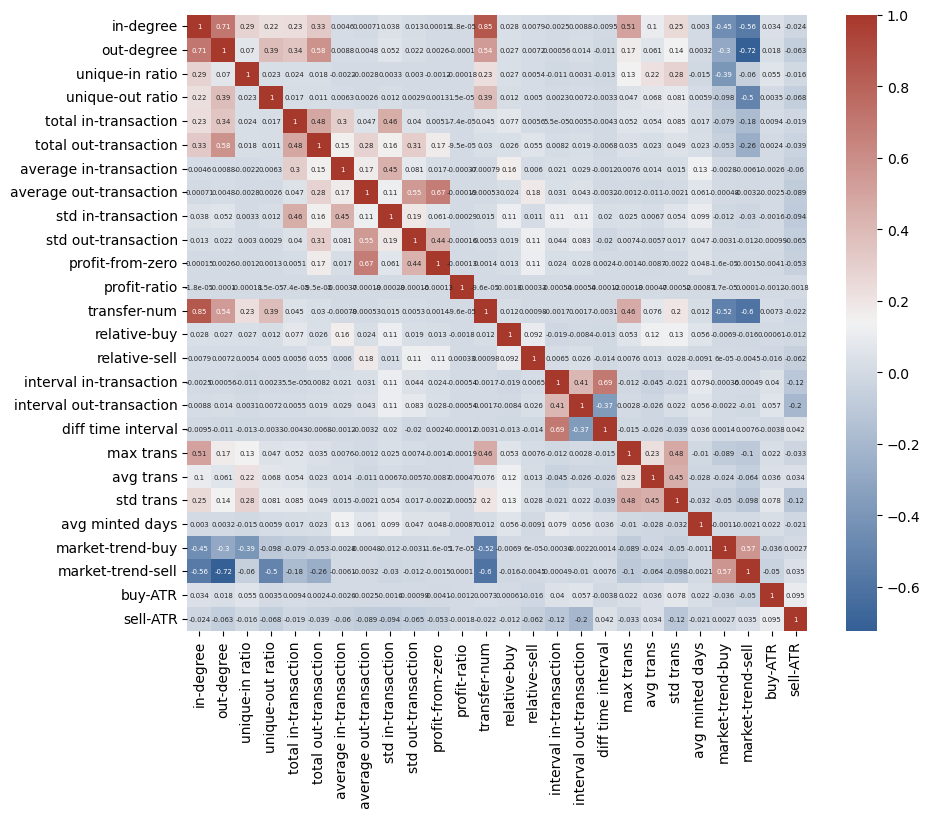

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cor = combined_features.corr()
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize = (10,8))
sns.heatmap(cor,annot=True,annot_kws={"size": 5},cmap=cmap)

In [46]:
combined_features.to_sql("features", conn, if_exists='replace', index=False)

252924